# 독립성

In [2]:
from sklearn.feature_selection import mutual_info_regression
import numpy as np

import torch
from transformers import CLIPVisionModelWithProjection, ViTForImageClassification, AutoModelForCausalLM
from transformers import AutoModel, AutoTokenizer

ckpt_path = '/home/jgryu/Weight_compression/llm-awq/model_cache/models--meta-llama--Meta-Llama-3-8B/snapshots/8cde5ca8380496c9a6cc7ef3a8b46a0372a1d920'
net = AutoModelForCausalLM.from_pretrained(ckpt_path, local_files_only=True)

# mean = np.load(f'/home/jgryu/Weight_compression/Wparam_dataset/TFRecord/meta-llama--Meta-Llama-3-8B/mlp/d16/mlp_d16_train_mean.npy')
# std = np.load(f'/home/jgryu/Weight_compression/Wparam_dataset/TFRecord/meta-llama--Meta-Llama-3-8B/mlp/d16/mlp_d16_train_std.npy')
# mean = torch.from_numpy(mean)
# std = torch.from_numpy(std)

state_dict = net.state_dict()

for k, v in state_dict.items():
    print(k, v.shape)


/home/jgryu/miniconda3/envs/Wcomp/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 4/4 [00:07<00:00,  1.89s/it]

model.embed_tokens.weight torch.Size([128256, 4096])
model.layers.0.self_attn.q_proj.weight torch.Size([4096, 4096])
model.layers.0.self_attn.k_proj.weight torch.Size([1024, 4096])
model.layers.0.self_attn.v_proj.weight torch.Size([1024, 4096])
model.layers.0.self_attn.o_proj.weight torch.Size([4096, 4096])
model.layers.0.mlp.gate_proj.weight torch.Size([14336, 4096])
model.layers.0.mlp.up_proj.weight torch.Size([14336, 4096])
model.layers.0.mlp.down_proj.weight torch.Size([4096, 14336])
model.layers.0.input_layernorm.weight torch.Size([4096])
model.layers.0.post_attention_layernorm.weight torch.Size([4096])
model.layers.1.self_attn.q_proj.weight torch.Size([4096, 4096])
model.layers.1.self_attn.k_proj.weight torch.Size([1024, 4096])
model.layers.1.self_attn.v_proj.weight torch.Size([1024, 4096])
model.layers.1.self_attn.o_proj.weight torch.Size([4096, 4096])
model.layers.1.mlp.gate_proj.weight torch.Size([14336, 4096])
model.layers.1.mlp.up_proj.weight torch.Size([14336, 4096])
model.

## Distance Correlation

In [ ]:
import dcor
import numpy as np
import json
# 샘플 데이터 생성
plot_data_dcor = {}
dims = [1024, 256, 128, 32, 8, 4, 2, 512, 64, 16]
# dim = 1024
for dim in dims:
    for k, v in state_dict.items():
        if 'embed' in k or 'layernorm' in k: continue
        if 'layers.0.' in k or 'layers.1.' in k or 'layers.10.' in k or 'layers.30.' in k:
            print(k)
            plot_data_dcor[k] = {}
            for transpose in [False, True]:
                np.random.seed(1)
                print(f'Transpose : {transpose}')
                # print(f'#### chunk size : {dim} ####')
                if transpose:
                    v = v.T
                num_samples = 4096
                indices = torch.randperm(v.shape[0])[:num_samples]  # 무작위로 인덱스 선택
                W = v.reshape(-1, dim)[indices]
                # print(W.shape)

                d = W.shape[-1] // 2
                tensor_split = torch.split(W, d, dim=1)  # dim=1에서 64씩 나눔
                
                X = tensor_split[0]  # 첫 번째 (-1, 64)
                Y = tensor_split[1]  # 두 번째 (-1, 64)
                
                indices = torch.randperm(X.shape[0])
                X = X[indices]
                Y = Y[indices]
                # print(X.shape, Y.shape)

                dc = dcor.distance_correlation(X, Y)
                # print(f"Distance Correlation: {dc}")
                # plot_data[f'{transpose}'].append(dc)
                plot_data_dcor[k][f'{transpose}'] = dc
                print(dc)
                
                # 독립 여부 판단
                # if dc < 1e-3:  # Threshold는 상황에 따라 조정 가능
                #     print("Variables are likely independent.")
                # else:
                #     print("Variables are dependent.")
    output_filename = f"/home/jgryu/Weight_compression/test_normality/dependency/distance_cor_dim_{dim}.json"
    with open(output_filename, 'w') as json_file:
        json.dump(plot_data_dcor, json_file, indent=4)

In [ ]:
import matplotlib.pyplot as plt

# 카테고리와 값을 추출
categories = []
values = []
colors = []  # 색상 저장
for k, v in plot_data_dcor.items():
    for transpose, dc_value in v.items():
        categories.append(f"{k}_{transpose}")
        values.append(dc_value)
        colors.append('skyblue' if transpose == 'False' else 'orange')  # False는 skyblue, True는 orange

# 막대그래프 생성
plt.figure(figsize=(12, 6))
plt.bar(categories, values, color=colors, edgecolor='black')

# y = 1e-3 직선 추가
plt.axhline(y=1e-3, color='red', linestyle='--', linewidth=1, label='y = 1e-3')

# 그래프 레이블 추가
plt.title('Distance Correlation by Layer and Transpose', fontsize=16)
plt.xlabel('Layer and Transpose', fontsize=12)
plt.ylabel('Distance Correlation', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=3)  # 폰트 크기 8로 조정

# # 각 막대 위에 값 표시
# for i, value in enumerate(values):
#     plt.text(i, value + 0.01, f"{value:.2f}", ha='center', fontsize=10)

# 범례 추가
plt.legend(['y = 1e-3', 'False (skyblue)', 'True (orange)'], loc='upper right')

# 레이아웃 최적화 및 그래프 출력
plt.tight_layout()
plt.show()


In [ ]:
import dcor
import numpy as np

# 샘플 데이터 생성
plot_data = {}
dims = [4096, 2048, 1024, 512, 256, 128, 64, 32, 16, 8, 4, 2]

for k, v in state_dict.items():
    if 'embed' in k and 'layernorm' in k: continue
    for transpose in [False, True]:
        np.random.seed(1)
        print(f'Transpose : {transpose}')
        plot_data[f'{transpose}'] = []
        for dim in dims:
            # print(f'#### chunk size : {dim} ####')
            if transpose:
                v = v.T
            num_samples = 4096
            indices = torch.randperm(v.shape[0])[:num_samples]  # 무작위로 인덱스 선택
            W = v.reshape(-1, dim)[indices]
            # print(W.shape)

            d = W.shape[-1] // 2
            tensor_split = torch.split(W, d, dim=1)  # dim=1에서 64씩 나눔
            
            X = tensor_split[0]  # 첫 번째 (-1, 64)
            Y = tensor_split[1]  # 두 번째 (-1, 64)
            
            indices = torch.randperm(X.shape[0])
            X = X[indices]
            Y = Y[indices]
            # print(X.shape, Y.shape)

            dc = dcor.distance_correlation(X, Y)
            # print(f"Distance Correlation: {dc}")
            plot_data[f'{transpose}'].append(dc)
            # 독립 여부 판단
            # if dc < 1e-3:  # Threshold는 상황에 따라 조정 가능
            #     print("Variables are likely independent.")
            # else:
            #     print("Variables are dependent.")
                
    import matplotlib.pyplot as plt
    dims = [4096, 2048, 1024, 512, 256, 128, 64, 32, 16, 8, 4, 2]
    plt.figure(figsize=(6.5, 5))
    for l, v in plot_data.items():
        print(v)
        plt.plot(dims, v, marker='o', markersize = 3, linestyle='-', label=l)
        
        
    plt.title(f'{k}, Distance Correlation')
    plt.xlabel('size')
    plt.ylabel('dc')
    plt.legend()
    plt.grid(True)
    plt.xscale('log')

    plt.tight_layout()
    plt.show()

## 2. HSIC (Hilbert-Schmidt Independence Criterion)

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel
import json
# HSIC 계산 함수
def hsic(X, Y, sigma=1.0):  
    K = rbf_kernel(X, X, gamma=1 / (2 * sigma**2))  # X의 RBF 커널
    L = rbf_kernel(Y, Y, gamma=1 / (2 * sigma**2))  # Y의 RBF 커널
    n = K.shape[0]
    H = np.eye(n) - (1/n) * np.ones((n, n))
    
    HSIC_value = np.trace(K @ H @ L @ H) / (n - 1)**2
    return HSIC_value

# # 독립 여부 판단
# if hsic_value < 1e-3:  # Threshold 설정
#     print("Variables are likely independent.")
# else:
#     print("Variables are dependent.")

plot_data_hsic = {}
dims = [1024, 256, 128, 32, 8, 4, 2, 512, 64, 16]
# dim = 1024
for dim in dims:
    for k, v in state_dict.items():
        if 'embed' in k or 'layernorm' in k: continue
        if 'layers.0.' in k or 'layers.1.' in k or 'layers.10.' in k or 'layers.30.' in k:
            print(k)
            plot_data_hsic[k] = {}
            for transpose in [False, True]:
                np.random.seed(1)
                print(f'Transpose : {transpose}')
                # print(f'#### chunk size : {dim} ####')
                if transpose:
                    v = v.T
                num_samples = 4096
                indices = torch.randperm(v.shape[0])[:num_samples]  # 무작위로 인덱스 선택
                W = v.reshape(-1, dim)[indices]
                # print(W.shape)

                d = W.shape[-1] // 2
                tensor_split = torch.split(W, d, dim=1)  # dim=1에서 64씩 나눔
                
                X = tensor_split[0]  # 첫 번째 (-1, 64)
                Y = tensor_split[1]  # 두 번째 (-1, 64)
                
                indices = torch.randperm(X.shape[0])
                X = X[indices]
                Y = Y[indices]
                # print(X.shape, Y.shape)

                hsic_value = hsic(X, Y, sigma=1.0)
                print(f"HSIC Value: {hsic_value}")
                plot_data_hsic[k][f'{transpose}'] = hsic_value

    output_filename = f"/home/jgryu/Weight_compression/test_normality/dependency/hisc_dim_{dim}.json"
    with open(output_filename, 'w') as json_file:
        json.dump(plot_data_hsic, json_file, indent=4)

1024


/tmp/ipykernel_1924712/1592256546.py:43: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle((0, 0), 1, 1, color='skyblue', edgecolor='black'),  # False 색상
/tmp/ipykernel_1924712/1592256546.py:44: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle((0, 0), 1, 1, color='orange', edgecolor='black'),  # True 색상


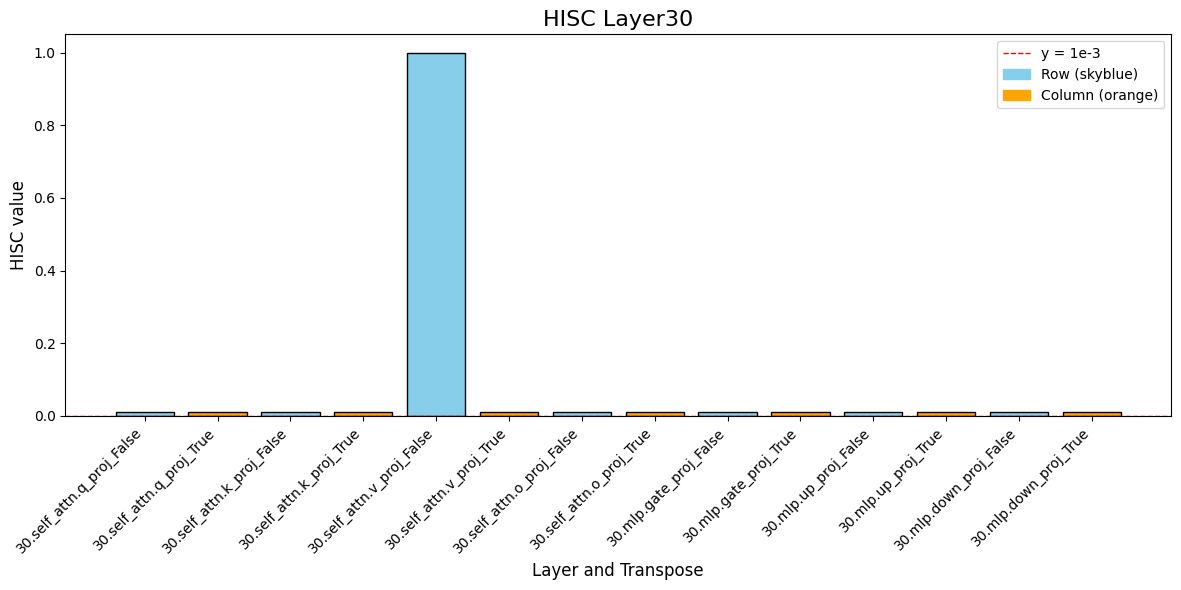

512


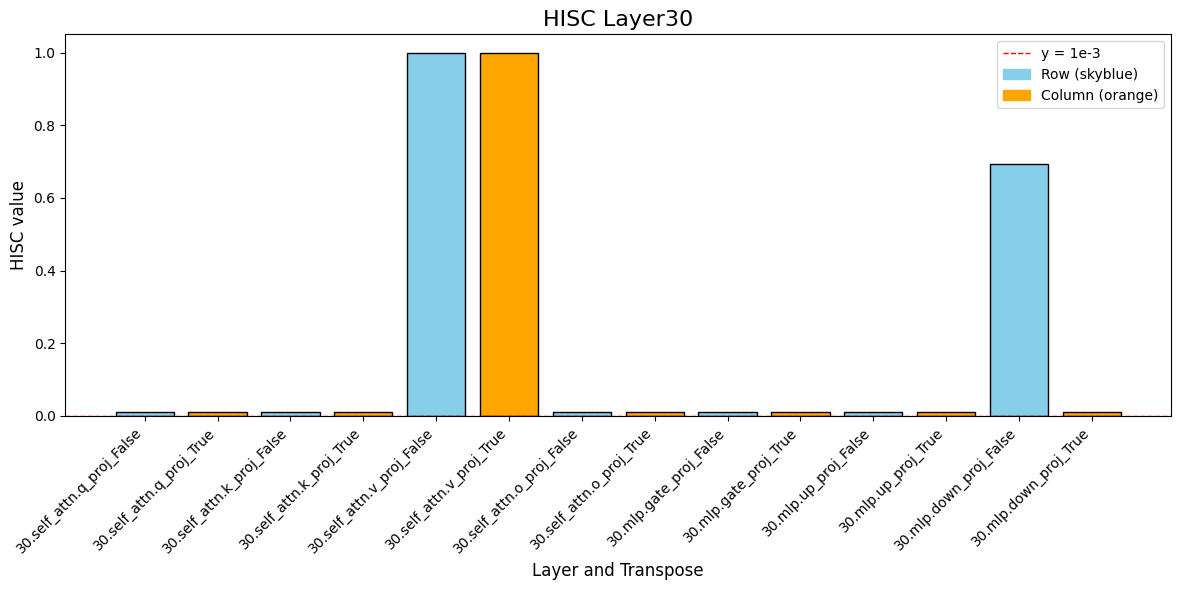

256


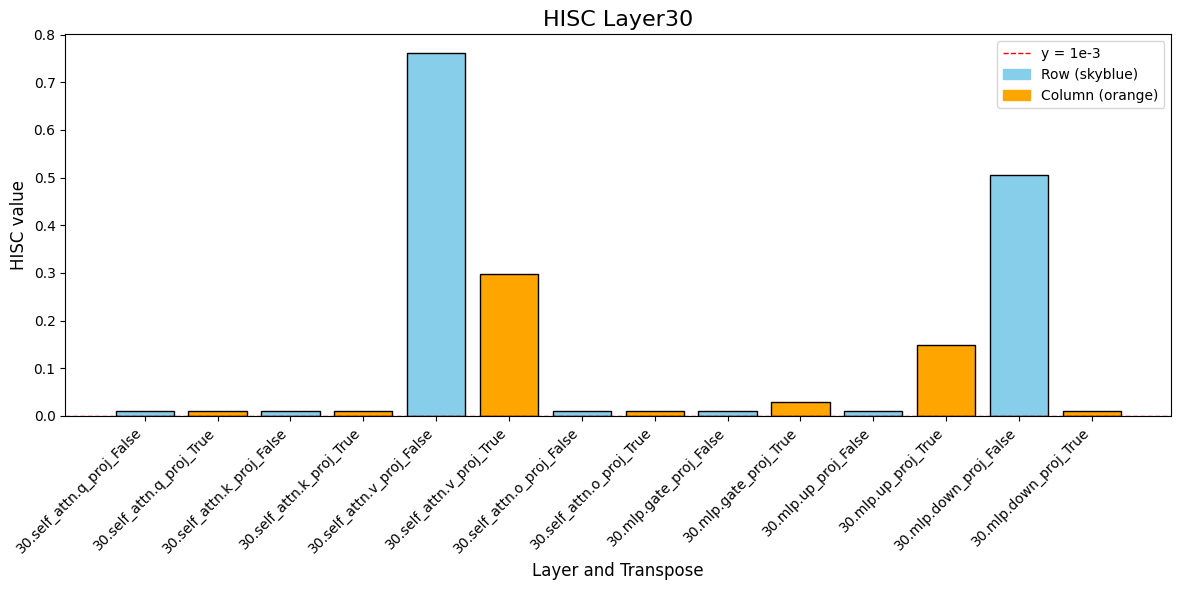

128


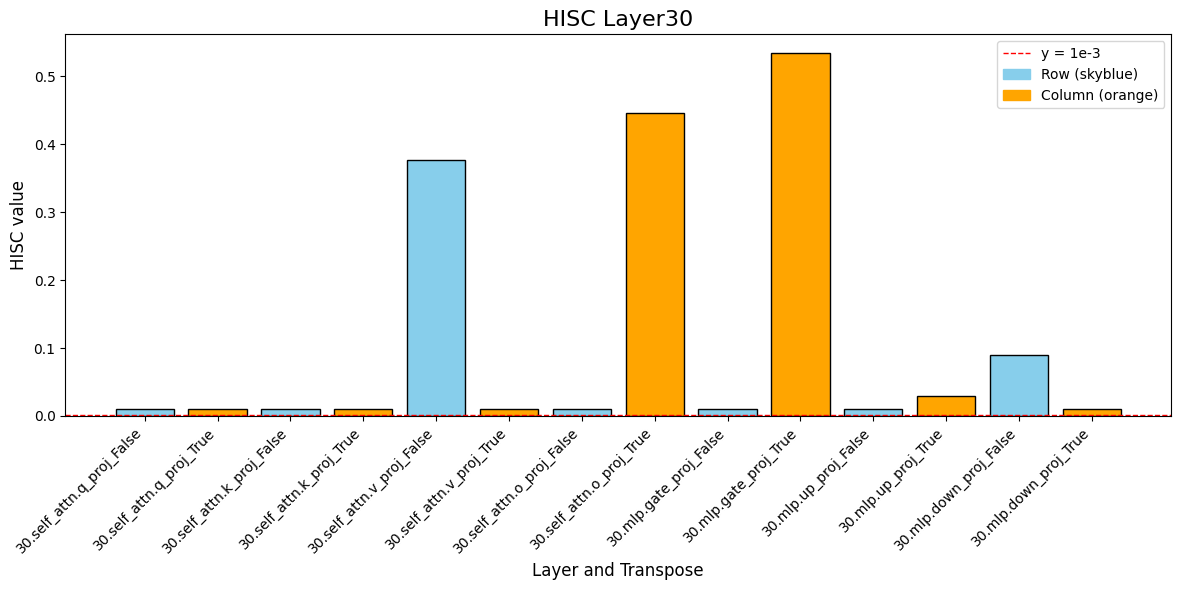

64


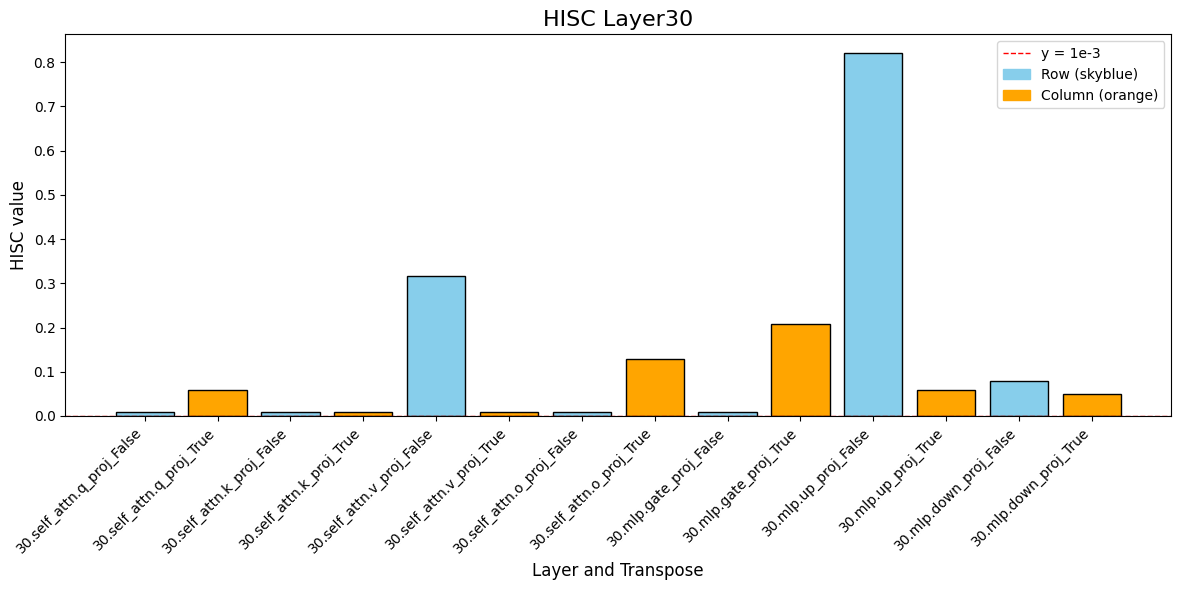

32


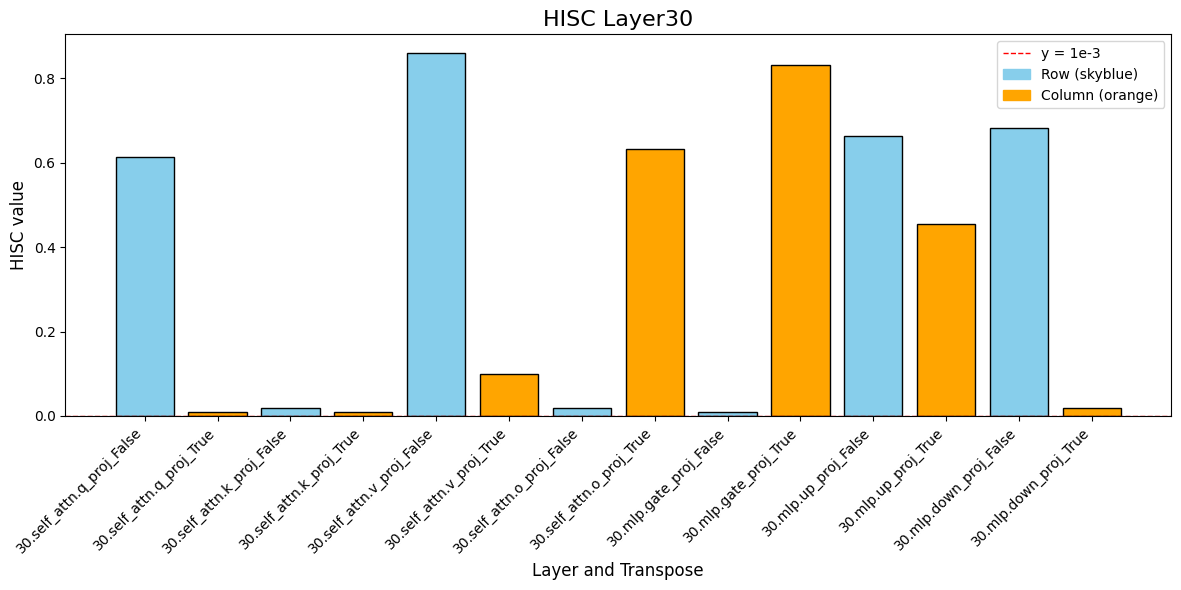

16


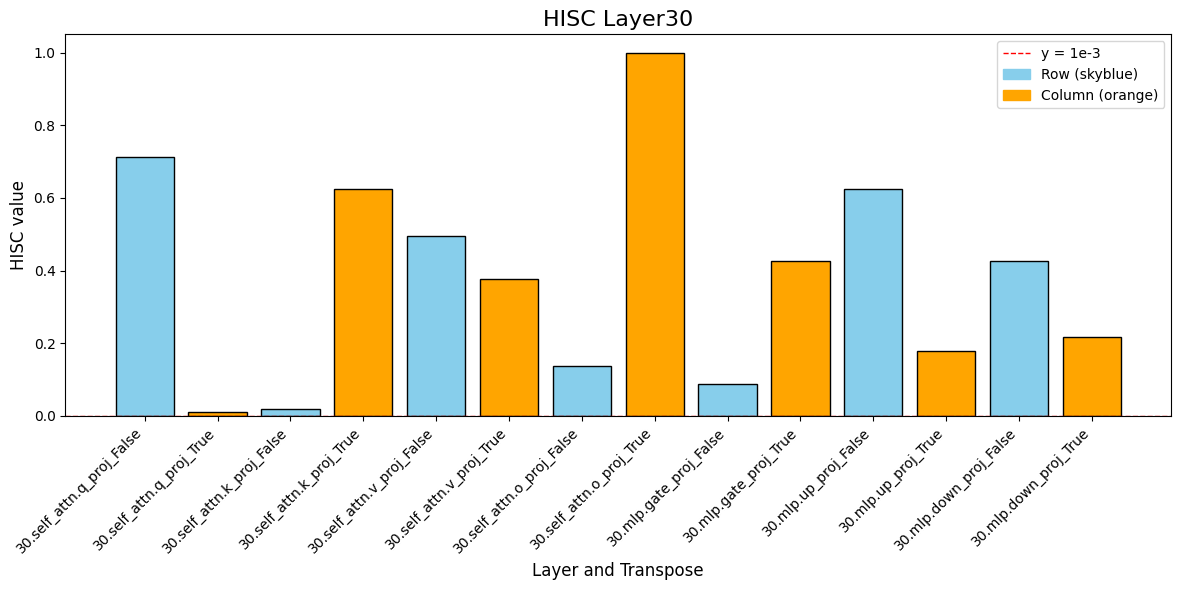

8


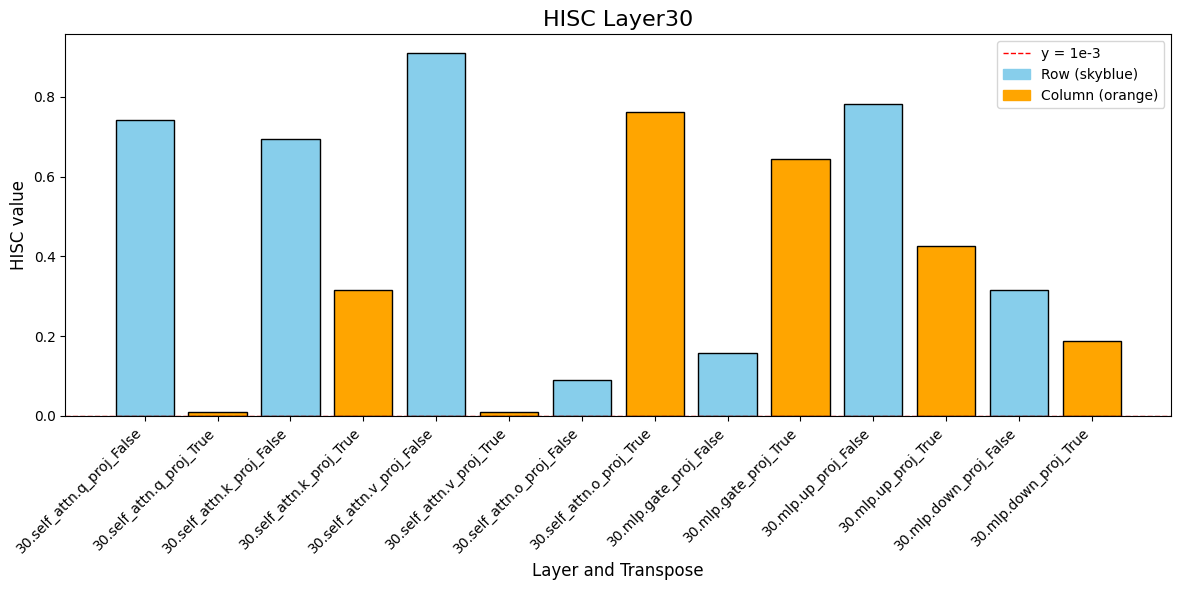

4


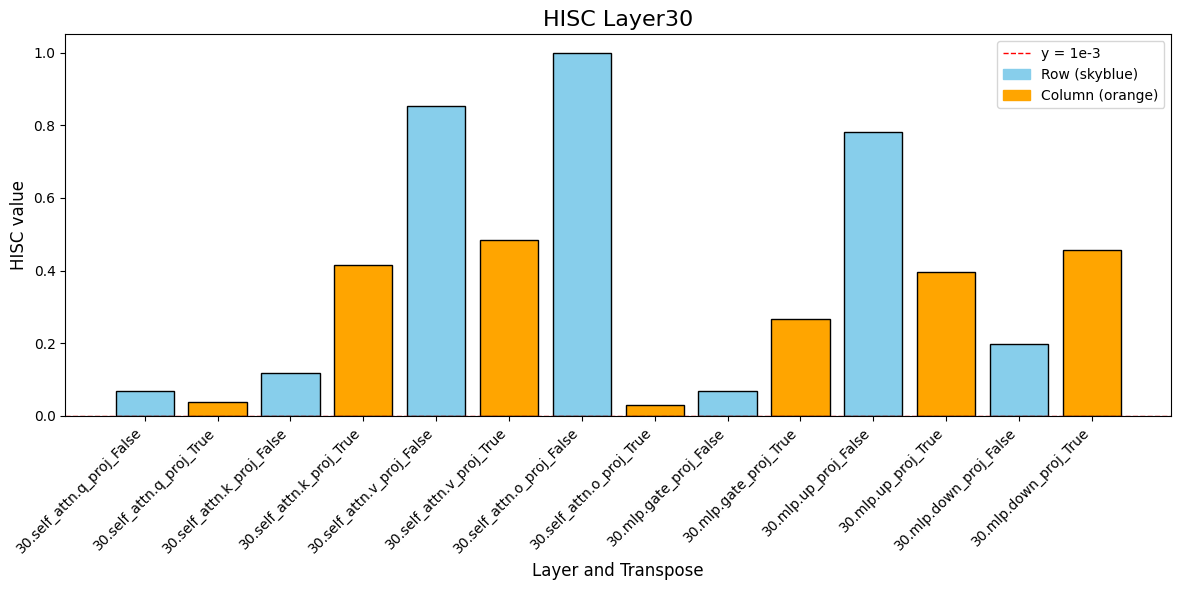

2


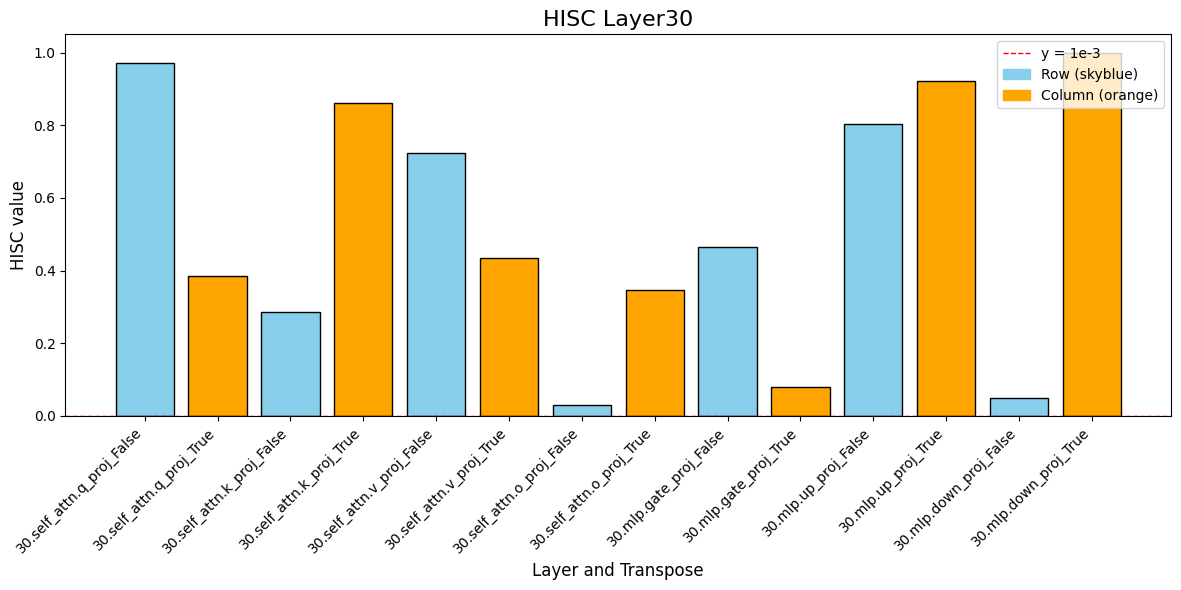

In [ ]:
import matplotlib.pyplot as plt
import json
# 카테고리와 값을 추출
dims = [1024, 512, 256, 128, 64, 32, 16, 8, 4, 2]
for dim in dims:
    try:
        print(dim)
        with open(f'/home/jgryu/Weight_compression/test_normality/dependency/hisc_dim_{dim}.json', 'r', encoding='utf-8') as file:
            plot_data = json.load(file)  # JSON 파일을 Python 객체로 변환

        categories = []
        values = []
        colors = []  # 색상 저장
        for k, v in plot_data.items():
            # if 'layers.0.' in k or 'layers.1.' in k or 'layers.10.' in k or 'layers.30.' in k:
            if 'layers.30.' in k:
                for transpose, dc_value in v.items():
                    categories.append(f"{'.'.join(k.split('.')[2:5])}_{transpose}")
                    values.append(dc_value)
                    colors.append('skyblue' if transpose == 'False' else 'orange')  # False는 skyblue, True는 orange

        # 막대그래프 생성
        plt.figure(figsize=(12, 6))
        plt.bar(categories, values, color=colors, edgecolor='black')

        # y = 1e-3 직선 추가
        plt.axhline(y=1e-3, color='red', linestyle='--', linewidth=1, label='y = 1e-3')

        # 그래프 레이블 추가
        plt.title('HISC Layer30', fontsize=16)
        plt.xlabel('Layer and Transpose', fontsize=12)
        plt.ylabel('HISC value', fontsize=12)
        plt.xticks(rotation=45, ha='right', fontsize=10)  # 폰트 크기 8로 조정

        # # 각 막대 위에 값 표시
        # for i, value in enumerate(values):
        #     plt.text(i, value + 0.01, f"{value:.2f}", ha='center', fontsize=10)

        # 범례 추가
        plt.legend(
            [
                plt.Line2D([0], [0], color='red', linestyle='--', linewidth=1),  # y=1e-3 직선
                plt.Rectangle((0, 0), 1, 1, color='skyblue', edgecolor='black'),  # False 색상
                plt.Rectangle((0, 0), 1, 1, color='orange', edgecolor='black'),  # True 색상
            ],
            ['y = 1e-3', 'Row (skyblue)', 'Column (orange)'],  # 각각의 라벨
            loc='upper right'
        )

        # 레이아웃 최적화 및 그래프 출력
        plt.tight_layout()
        plt.show()


        # # 독립 여부 판단
        # if hsic_value < 1e-3:  # Threshold 설정
        #     print("Variables are likely independent.")
        # else:
        #     print("Variables are dependent.")
    except:
        continue
    
## 작으면 독립

## Permuation HISC

1024
[0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.00

/tmp/ipykernel_1924712/678728973.py:44: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle((0, 0), 1, 1, color='skyblue', edgecolor='black'),  # False 색상
/tmp/ipykernel_1924712/678728973.py:45: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle((0, 0), 1, 1, color='orange', edgecolor='black'),  # True 색상


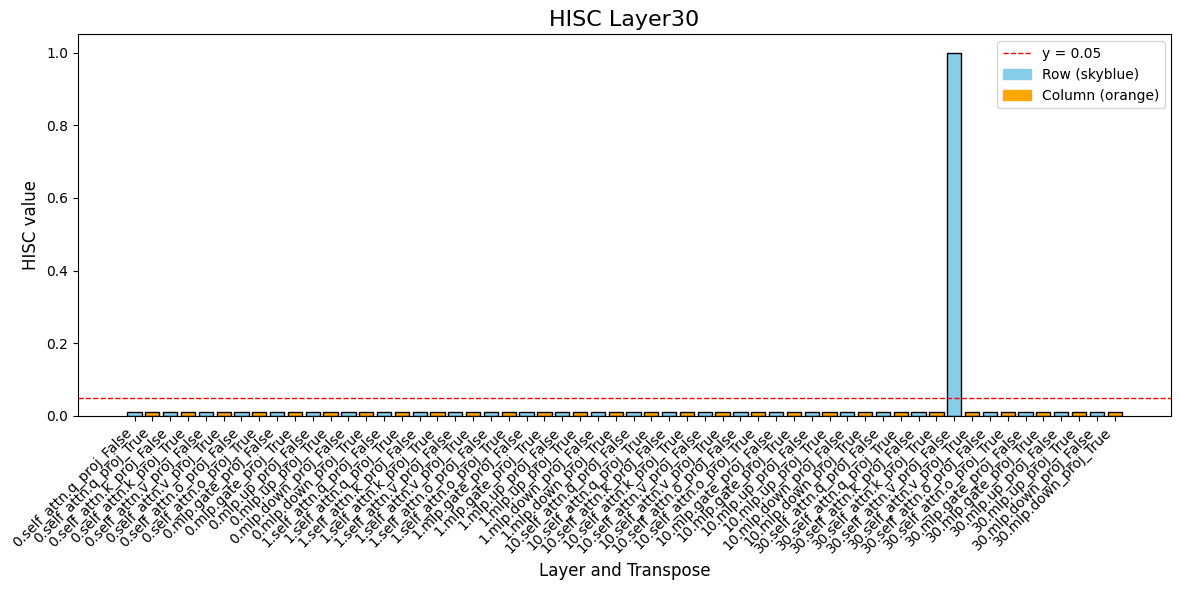

512
[0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.019801980198019802, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.0297029702970297, 0.0297029702970297, 0.32673267326732675, 0.22772277227722773, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.5247524752475248, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.00990099009

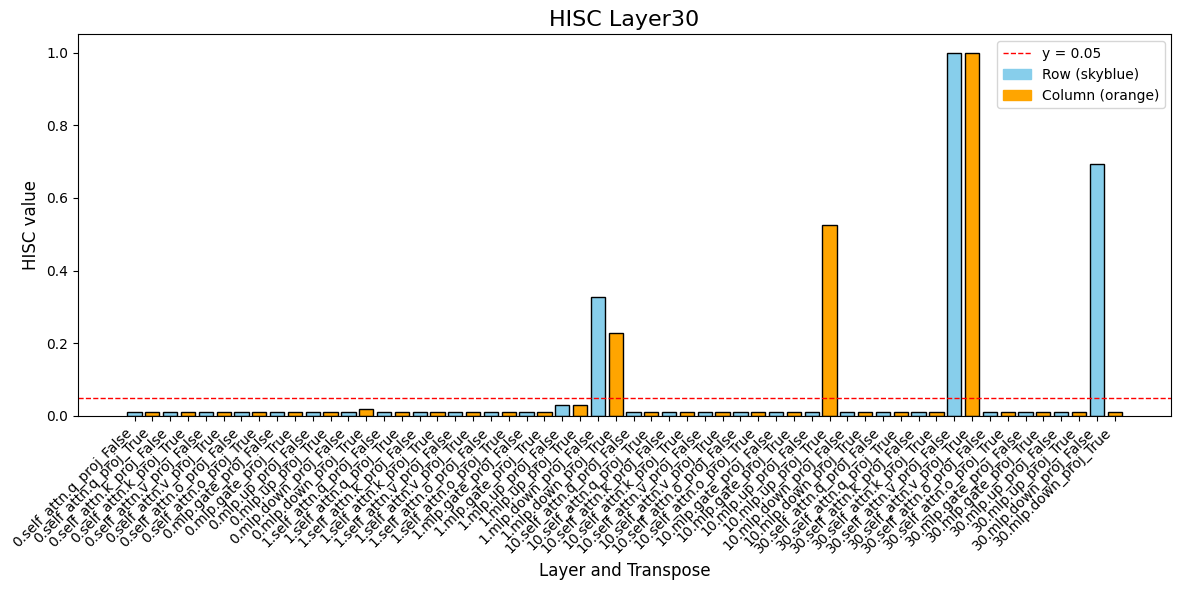

256
[0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.38613861386138615, 0.009900990099009901, 0.33663366336633666, 0.009900990099009901, 0.019801980198019802, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.04950495049504951, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.0297029702970297, 0.22772277227722773, 0.009900990099009901, 0.24752475247524752, 0.5742574257425742, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.12871287128712872, 0.04950495049504951, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.00990099009900

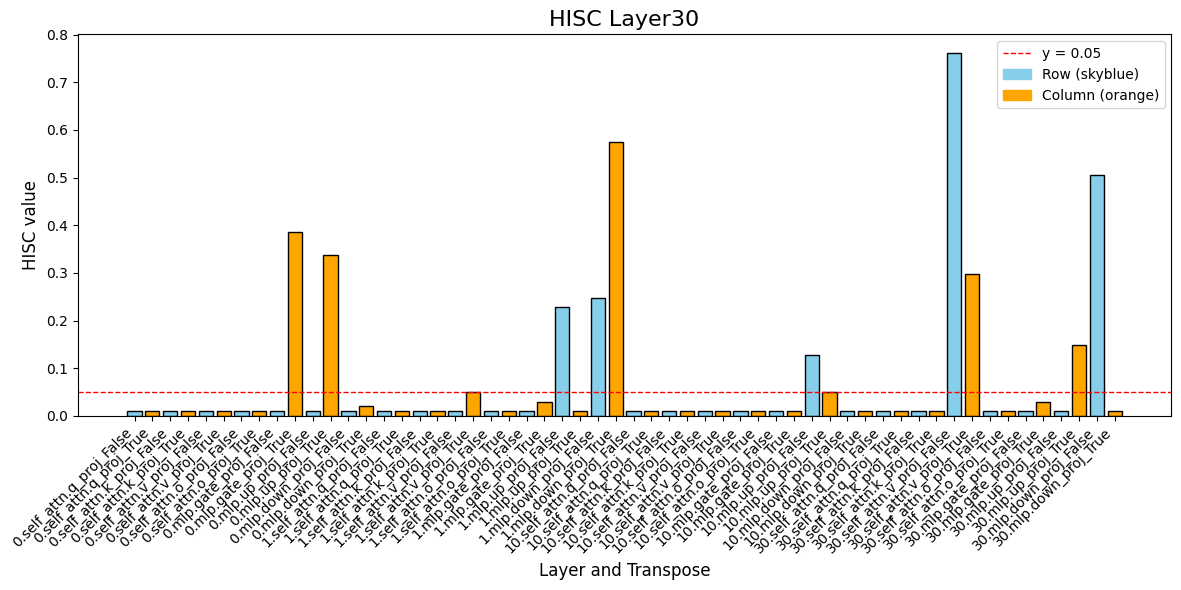

128
[0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.5148514851485149, 0.9108910891089109, 0.7920792079207921, 0.09900990099009901, 0.9306930693069307, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.1188118811881188, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.2079207920792079, 0.04950495049504951, 0.12871287128712872, 0.7524752475247525, 0.039603960396039604, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.8613861386138614, 0.009900990099009901, 0.04950495049504951, 0.4752475247524752, 0.8910891089108911, 0.19801980198019803, 0.039603960396039604, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.376237

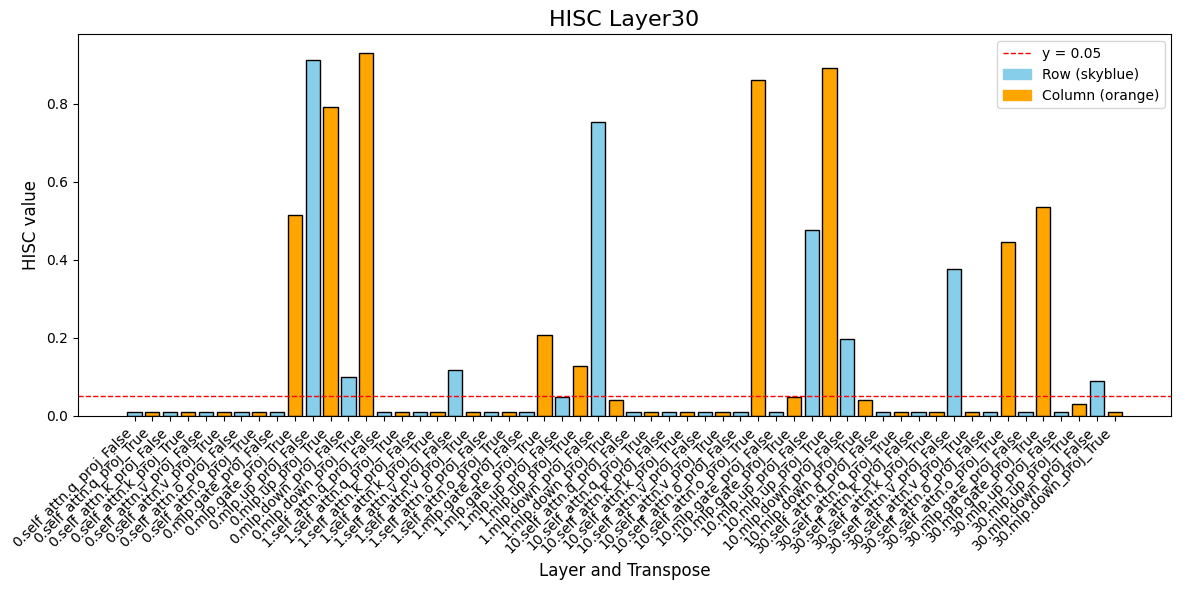

64
[0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.15841584158415842, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.07920792079207921, 0.25742574257425743, 0.8613861386138614, 0.0594059405940594, 0.039603960396039604, 0.9405940594059405, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.37623762376237624, 0.009900990099009901, 0.009900990099009901, 0.15841584158415842, 0.27722772277227725, 0.10891089108910891, 0.039603960396039604, 0.9108910891089109, 0.5841584158415841, 0.9702970297029703, 0.009900990099009901, 0.3465346534653465, 0.009900990099009901, 0.009900990099009901, 0.22772277227722773, 0.009900990099009901, 0.009900990099009901, 0.9306930693069307, 0.009900990099009901, 0.1188118811881188, 0.9306930693069307, 0.1782178217821782, 0.15841584158415842, 0.0891089108910891, 0.009900990099009901, 0.0594059405940594, 0.009900990099009901, 0.009900990099009901, 0.31683168316831684

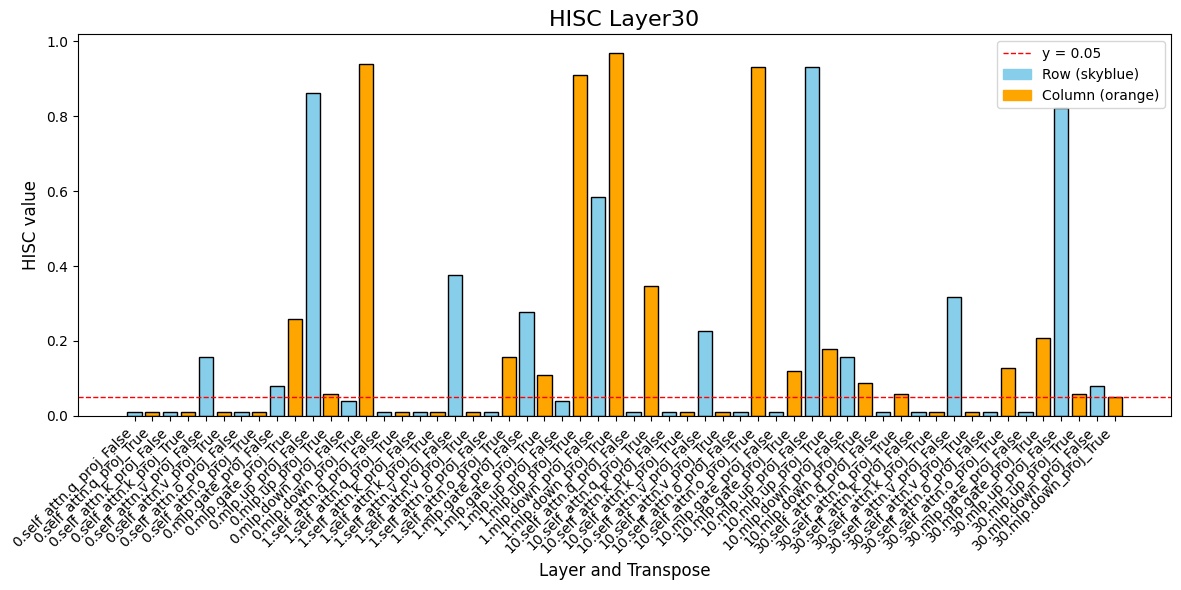

32
[0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.6237623762376238, 0.009900990099009901, 0.009900990099009901, 0.27722772277227725, 0.6435643564356436, 0.3564356435643564, 0.693069306930693, 0.6732673267326733, 0.0297029702970297, 0.43564356435643564, 0.0594059405940594, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.9306930693069307, 0.24752475247524752, 0.009900990099009901, 0.1782178217821782, 0.019801980198019802, 0.44554455445544555, 0.9108910891089109, 0.6237623762376238, 0.06930693069306931, 0.8910891089108911, 0.04950495049504951, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.2079207920792079, 0.009900990099009901, 0.009900990099009901, 0.5742574257425742, 0.009900990099009901, 0.38613861386138615, 0.44554455445544555, 0.40594059405940597, 0.5643564356435643, 0.7821782178217822, 0.6138613861386139, 0.009900990099009901, 0.019801980198019802, 0.009900990099009901, 0.8613861386138614, 0.099009

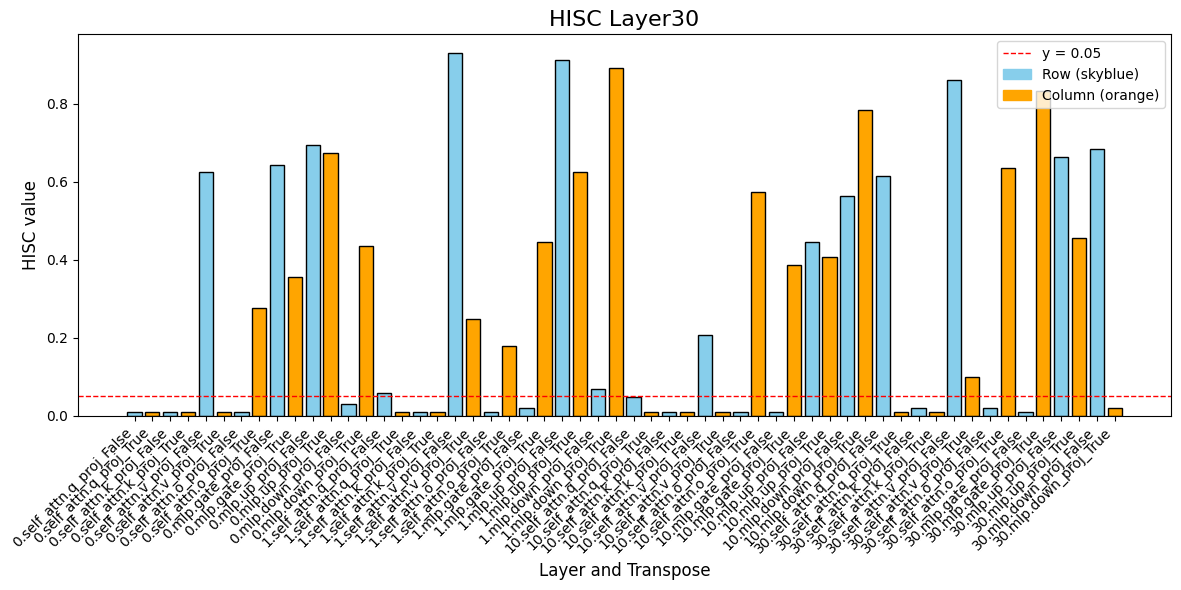

16
[0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.49504950495049505, 0.009900990099009901, 0.0297029702970297, 0.16831683168316833, 0.5742574257425742, 0.33663366336633666, 0.693069306930693, 0.13861386138613863, 0.42574257425742573, 0.7722772277227723, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.019801980198019802, 0.12871287128712872, 0.45544554455445546, 0.21782178217821782, 0.9900990099009901, 0.7722772277227723, 0.039603960396039604, 0.9801980198019802, 0.1188118811881188, 0.19801980198019803, 0.4752475247524752, 0.25742574257425743, 0.009900990099009901, 0.6435643564356436, 0.009900990099009901, 0.4752475247524752, 0.12871287128712872, 0.3069306930693069, 0.8712871287128713, 0.009900990099009901, 0.6633663366336634, 0.13861386138613863, 0.7623762376237624, 0.15841584158415842, 0.5148514851485149, 0.7128712871287128, 0.009900990099009901, 0.019801980198019802, 0.6237623762376238, 0.49504950495049505, 0.37623762376

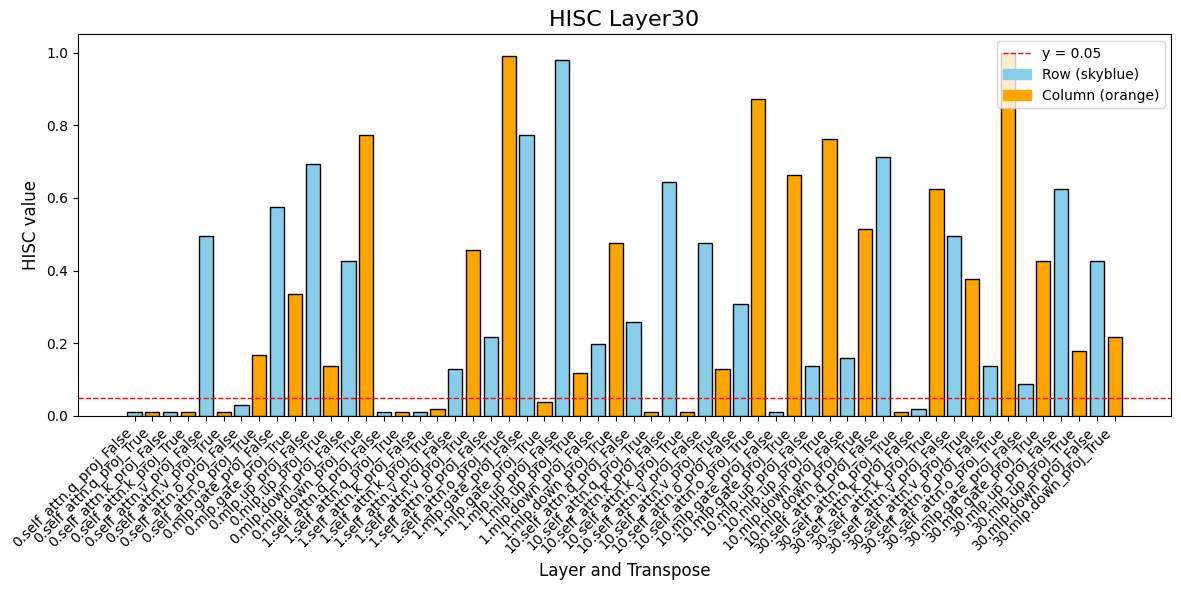

8
[0.09900990099009901, 0.009900990099009901, 0.009900990099009901, 0.009900990099009901, 0.7326732673267327, 0.019801980198019802, 0.43564356435643564, 0.42574257425742573, 0.09900990099009901, 0.8811881188118812, 0.5148514851485149, 0.43564356435643564, 0.3069306930693069, 0.19801980198019803, 0.039603960396039604, 0.9702970297029703, 0.297029702970297, 0.10891089108910891, 0.44554455445544555, 0.9801980198019802, 0.0594059405940594, 0.25742574257425743, 0.49504950495049505, 0.19801980198019803, 0.039603960396039604, 0.2871287128712871, 0.5346534653465347, 0.9504950495049505, 0.37623762376237624, 0.009900990099009901, 0.6237623762376238, 0.019801980198019802, 0.33663366336633666, 0.009900990099009901, 0.26732673267326734, 0.24752475247524752, 0.39603960396039606, 0.1782178217821782, 0.900990099009901, 0.48514851485148514, 0.8316831683168316, 0.8910891089108911, 0.7425742574257426, 0.009900990099009901, 0.693069306930693, 0.31683168316831684, 0.9108910891089109, 0.009900990099009901, 

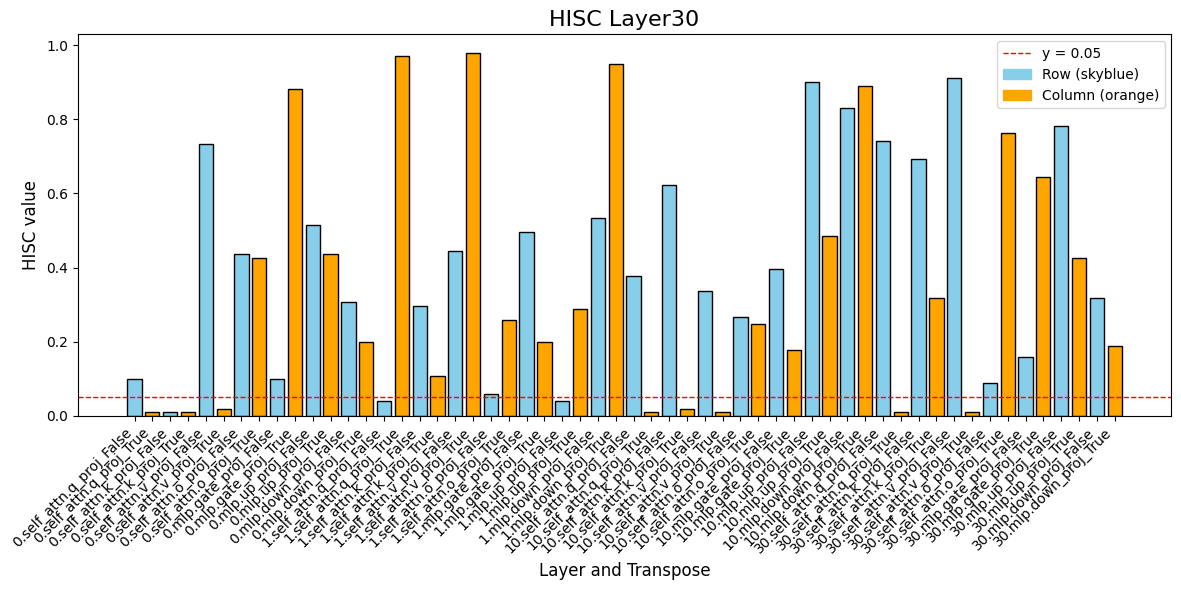

4
[0.5841584158415841, 0.06930693069306931, 0.8316831683168316, 0.009900990099009901, 0.12871287128712872, 0.49504950495049505, 0.46534653465346537, 0.009900990099009901, 0.06930693069306931, 0.9603960396039604, 0.6633663366336634, 0.45544554455445546, 0.5148514851485149, 0.5148514851485149, 0.07920792079207921, 0.10891089108910891, 0.7920792079207921, 0.33663366336633666, 0.21782178217821782, 0.900990099009901, 0.9900990099009901, 0.7029702970297029, 0.7524752475247525, 0.7128712871287128, 0.31683168316831684, 0.6237623762376238, 0.19801980198019803, 0.44554455445544555, 0.8811881188118812, 0.5544554455445545, 0.39603960396039606, 0.19801980198019803, 0.6732673267326733, 0.3564356435643564, 0.04950495049504951, 0.1485148514851485, 0.019801980198019802, 0.9900990099009901, 0.9504950495049505, 0.06930693069306931, 0.6534653465346535, 0.9603960396039604, 0.06930693069306931, 0.039603960396039604, 0.1188118811881188, 0.4158415841584158, 0.8514851485148515, 0.48514851485148514, 1.0, 0.0297

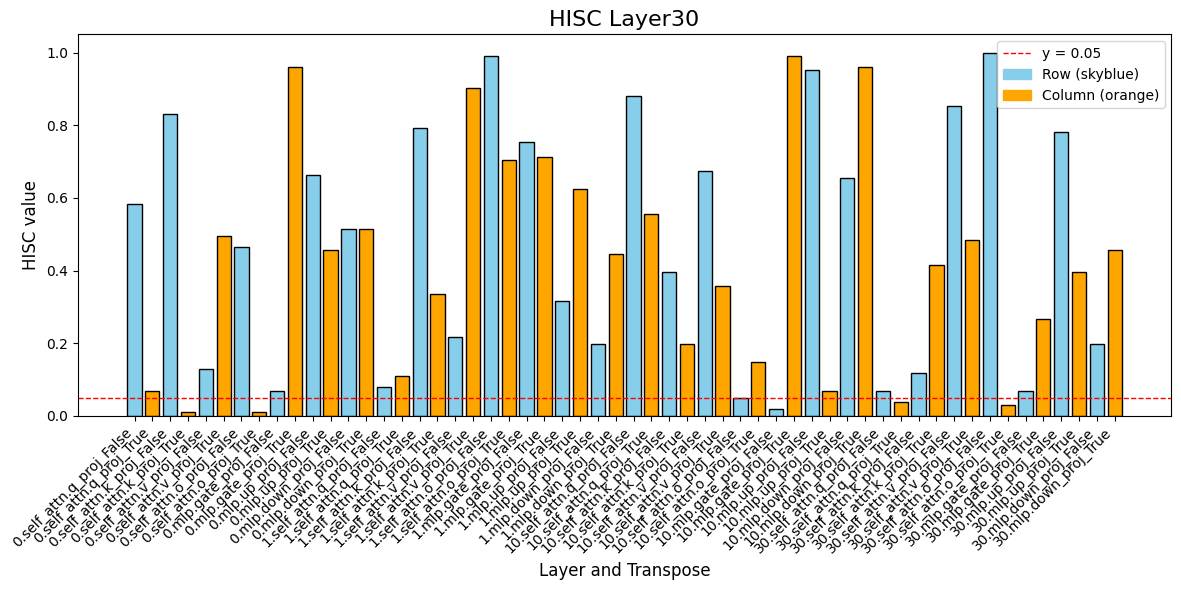

2
[0.7227722772277227, 0.06930693069306931, 0.504950495049505, 0.009900990099009901, 0.25742574257425743, 0.0891089108910891, 0.25742574257425743, 0.7425742574257426, 1.0, 0.38613861386138615, 0.7623762376237624, 0.039603960396039604, 0.42574257425742573, 0.13861386138613863, 0.6237623762376238, 0.7128712871287128, 0.6039603960396039, 0.8613861386138614, 0.6336633663366337, 0.7029702970297029, 0.6435643564356436, 0.2079207920792079, 0.7425742574257426, 0.7029702970297029, 0.07920792079207921, 0.07920792079207921, 0.0594059405940594, 0.5544554455445545, 0.46534653465346537, 0.04950495049504951, 0.12871287128712872, 0.27722772277227725, 0.5643564356435643, 0.22772277227722773, 0.900990099009901, 0.8316831683168316, 0.6534653465346535, 0.9603960396039604, 0.7524752475247525, 0.44554455445544555, 0.19801980198019803, 0.8712871287128713, 0.9702970297029703, 0.38613861386138615, 0.2871287128712871, 0.8613861386138614, 0.7227722772277227, 0.43564356435643564, 0.0297029702970297, 0.34653465346

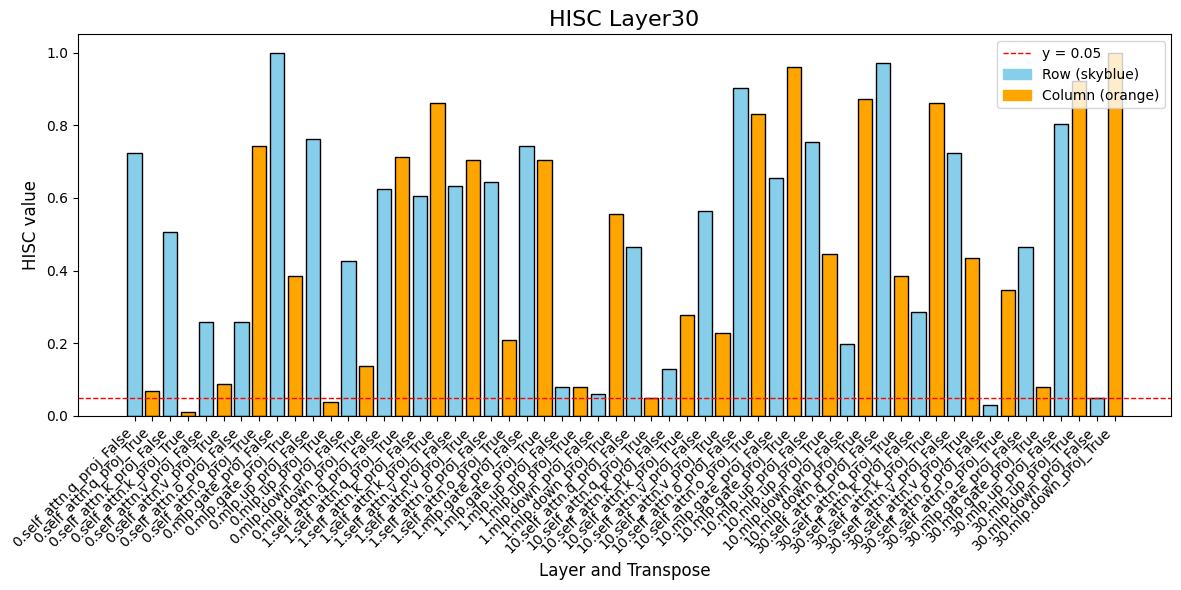

In [26]:
import matplotlib.pyplot as plt
import json
# 카테고리와 값을 추출
dims = [1024, 512, 256, 128, 64, 32, 16, 8, 4, 2]
for dim in dims:
    try:
        print(dim)
        with open(f'/home/jgryu/Weight_compression/test_normality/dependency/perm_hisc_dim_{dim}.json', 'r', encoding='utf-8') as file:
            plot_data = json.load(file)  # JSON 파일을 Python 객체로 변환

        categories = []
        values = []
        colors = []  # 색상 저장
        for k, v in plot_data.items():
            if 'layers.0.' in k or 'layers.1.' in k or 'layers.10.' in k or 'layers.30.' in k:
            # if 'layers.30.' in k:
                for transpose, dc_value in v.items():
                    categories.append(f"{'.'.join(k.split('.')[2:5])}_{transpose}")
                    values.append(dc_value)
                    colors.append('skyblue' if transpose == 'False' else 'orange')  # False는 skyblue, True는 orange

        # 막대그래프 생성
        plt.figure(figsize=(12, 6))
        plt.bar(categories, values, color=colors, edgecolor='black')
        print(values)

        # y = 1e-3 직선 추가
        plt.axhline(y=0.05, color='red', linestyle='--', linewidth=1, label='y = 0.05')

        # 그래프 레이블 추가
        plt.title('HISC Layer30', fontsize=16)
        plt.xlabel('Layer and Transpose', fontsize=12)
        plt.ylabel('HISC value', fontsize=12)
        plt.xticks(rotation=45, ha='right', fontsize=10)  # 폰트 크기 8로 조정

        # # 각 막대 위에 값 표시
        # for i, value in enumerate(values):
        #     plt.text(i, value + 0.01, f"{value:.2f}", ha='center', fontsize=10)

        # 범례 추가
        plt.legend(
            [
                plt.Line2D([0], [0], color='red', linestyle='--', linewidth=1),  # y=1e-3 직선
                plt.Rectangle((0, 0), 1, 1, color='skyblue', edgecolor='black'),  # False 색상
                plt.Rectangle((0, 0), 1, 1, color='orange', edgecolor='black'),  # True 색상
            ],
            ['y = 0.05', 'Row (skyblue)', 'Column (orange)'],  # 각각의 라벨
            loc='upper right'
        )

        # 레이아웃 최적화 및 그래프 출력
        plt.tight_layout()
        plt.show()


        # # 독립 여부 판단
        # if hsic_value < 1e-3:  # Threshold 설정
        #     print("Variables are likely independent.")
        # else:
        #     print("Variables are dependent.")
    except:
        continue
    
## 작으면 독립

1024


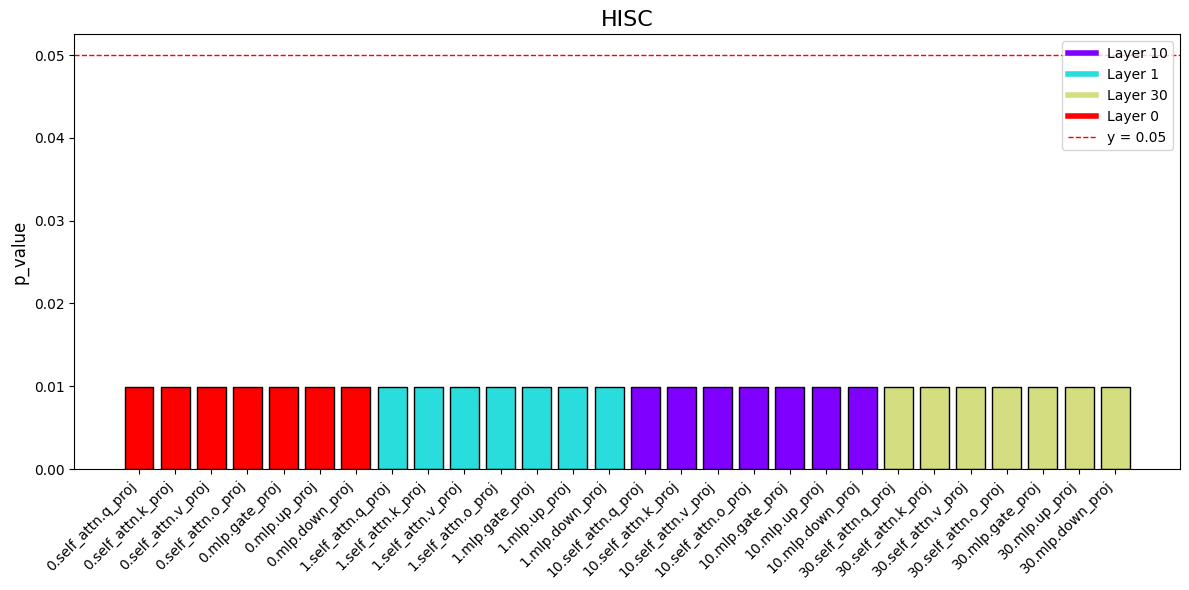

512


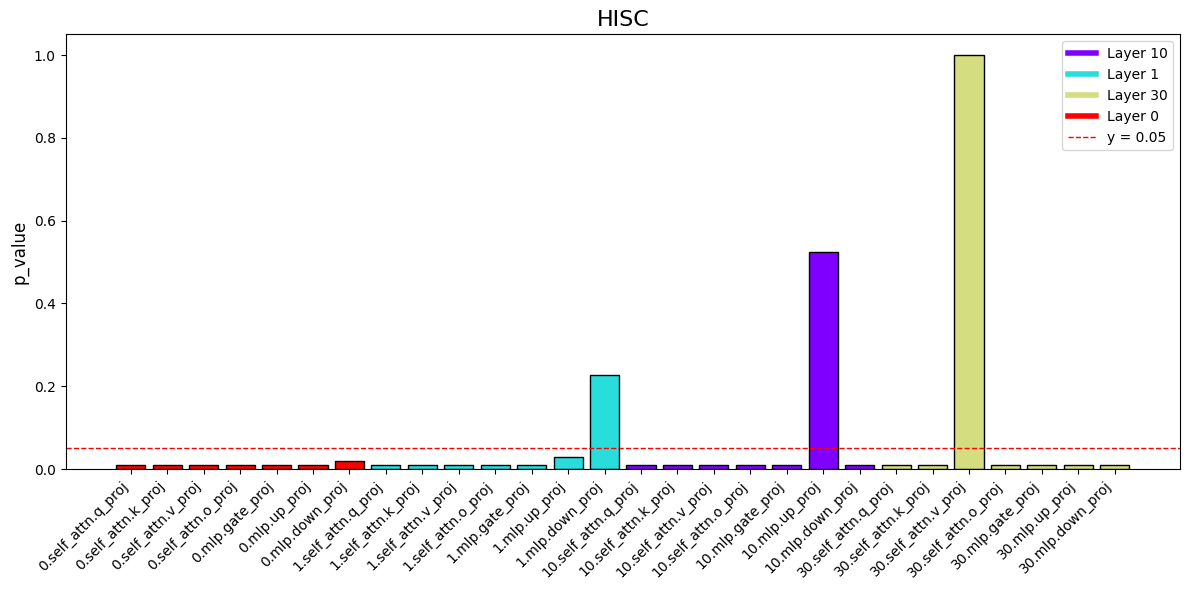

256


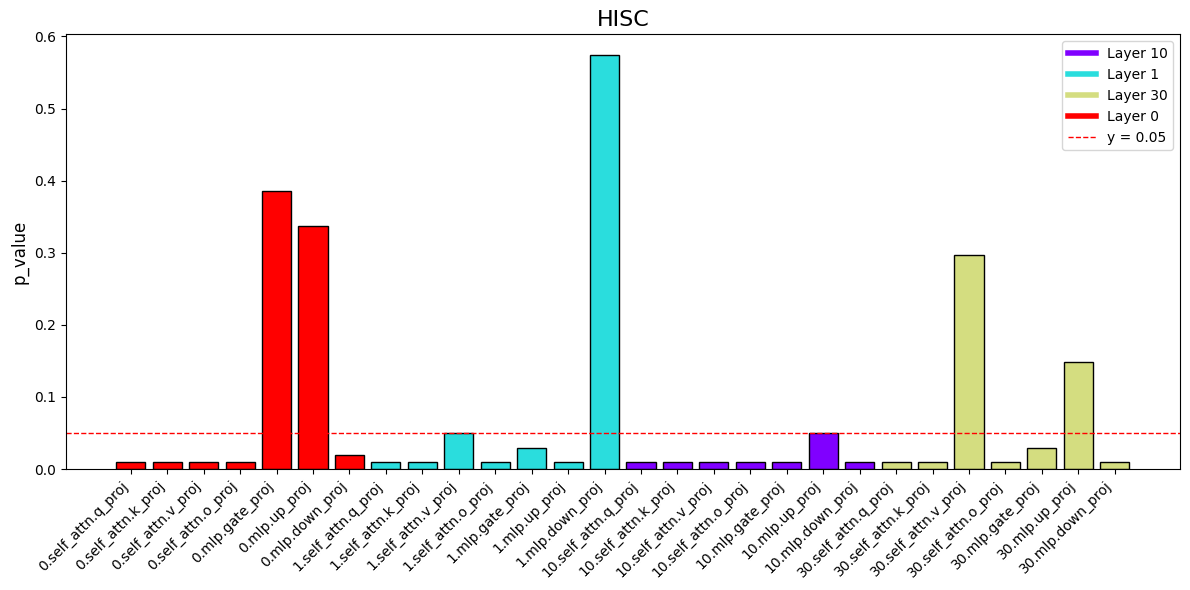

128


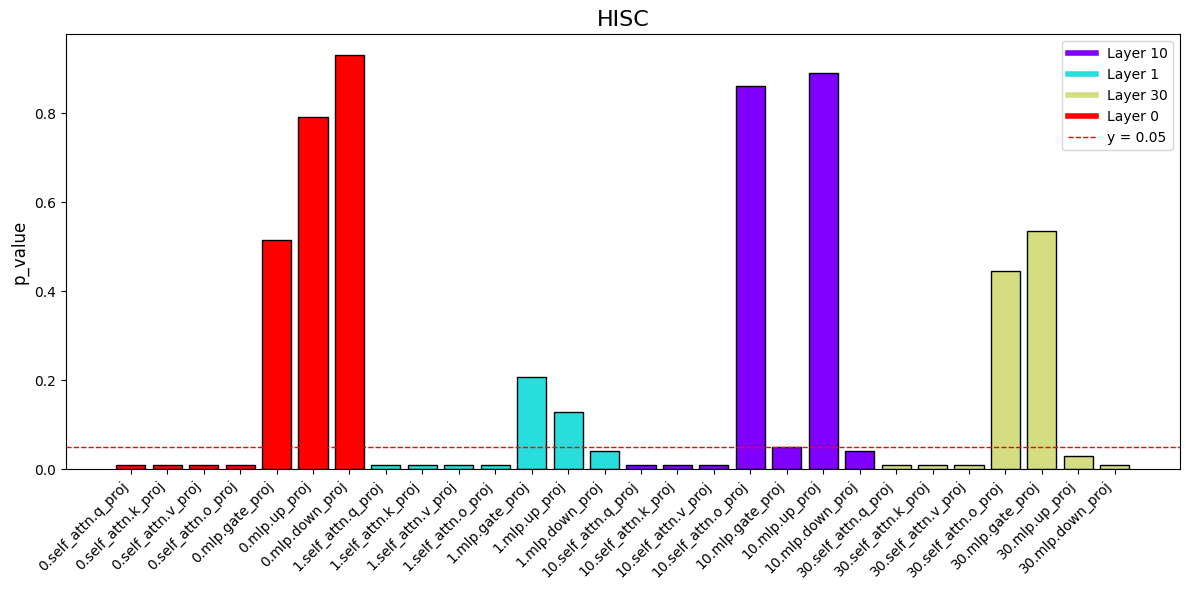

64


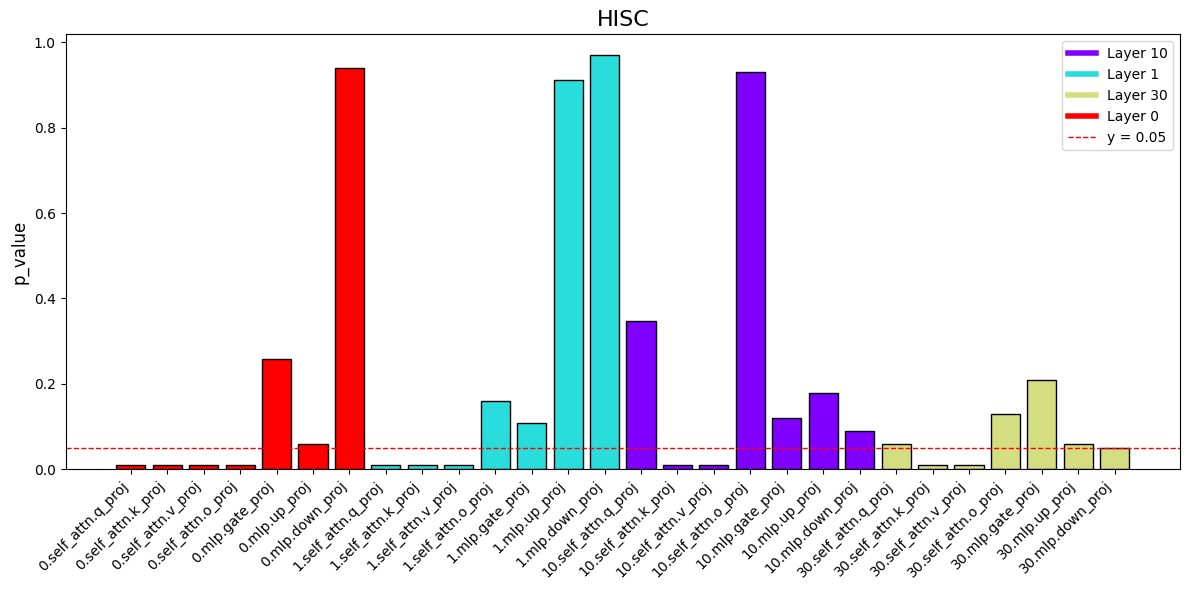

32


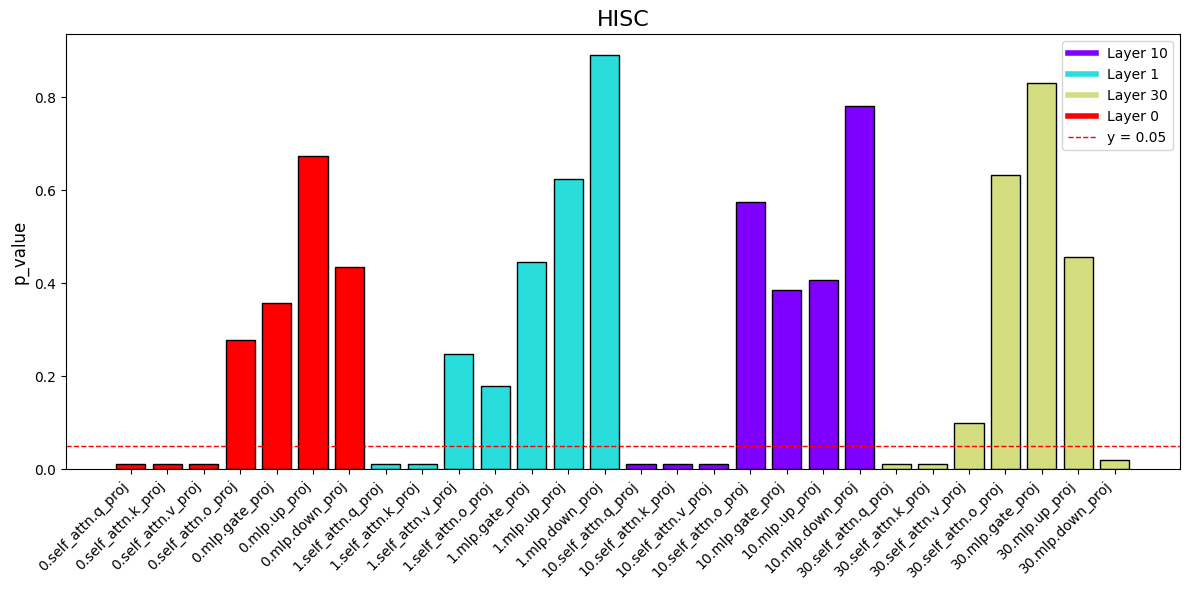

16


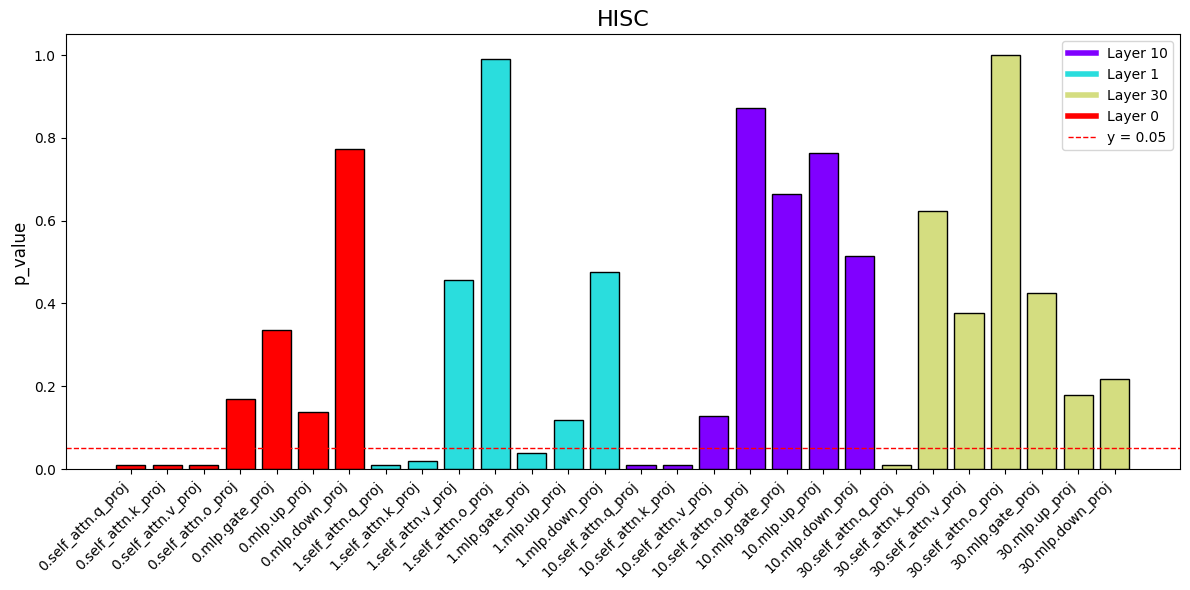

8


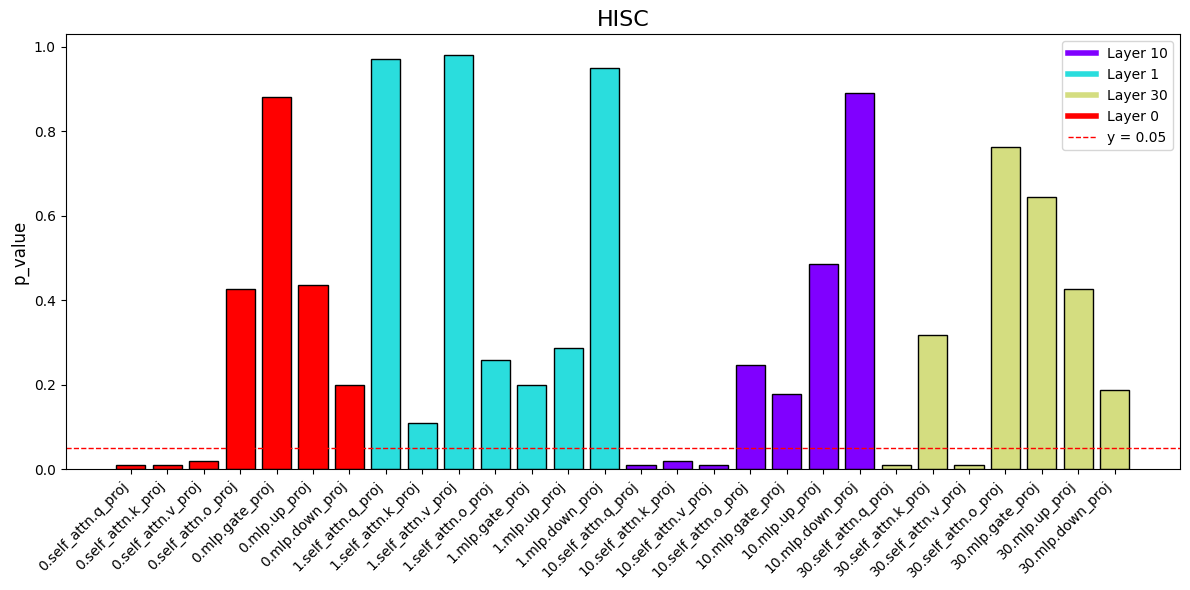

4


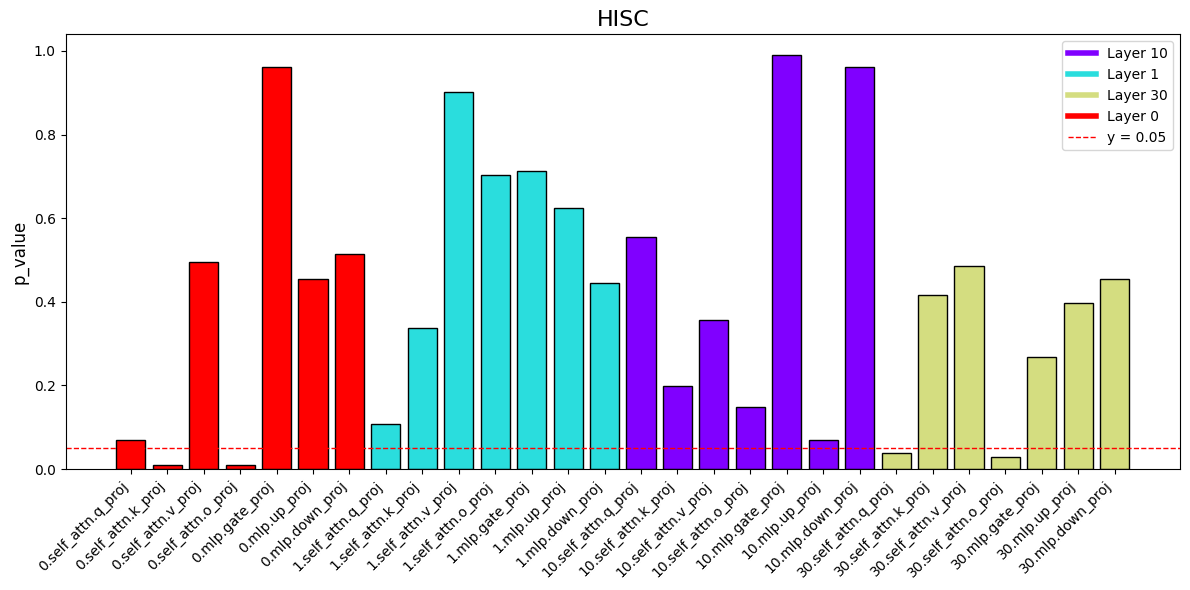

2


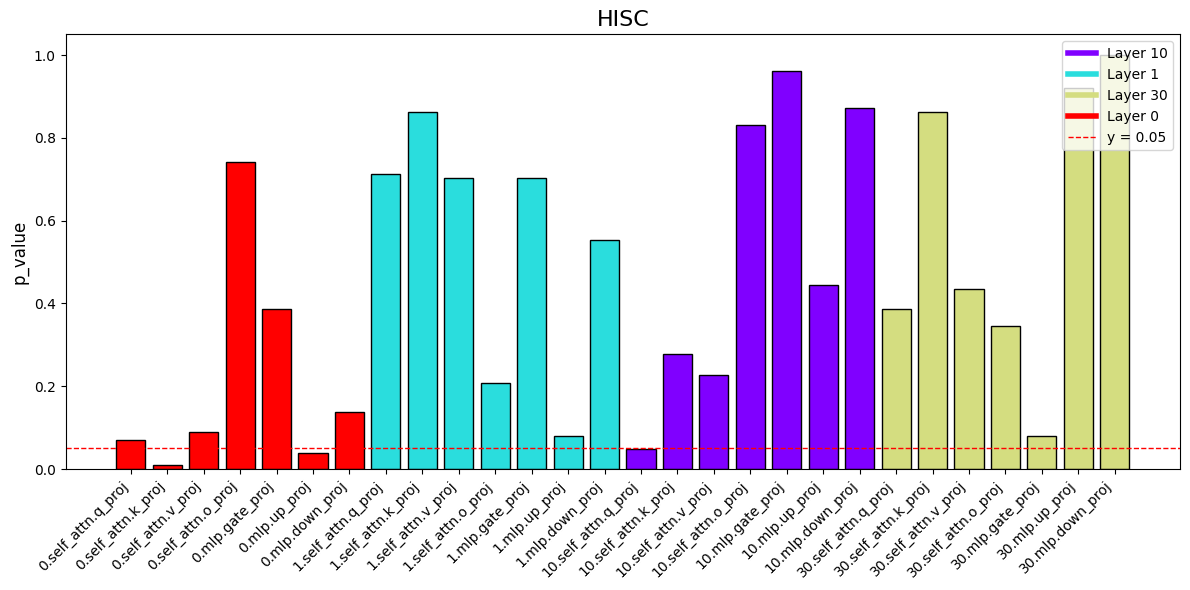

In [2]:
import matplotlib.pyplot as plt
import json
import matplotlib.cm as cm
import numpy as np

# 카테고리와 값을 추출
dims = [1024, 512, 256, 128, 64, 32, 16, 8, 4, 2]
for dim in dims:
    try:
        print(dim)
        with open(f'/home/jgryu/Weight_compression/test_normality/dependency/perm_hisc_dim_{dim}.json', 'r', encoding='utf-8') as file:
            plot_data = json.load(file)  # JSON 파일을 Python 객체로 변환

        categories = []
        values = []
        layer_indices = []  # layer index 저장
        for k, v in plot_data.items():
            if 'layers.0.' in k or 'layers.1.' in k or 'layers.10.' in k or 'layers.30.' in k:
                for transpose, dc_value in v.items():
                    if transpose == 'True':
                        categories.append(f"{'.'.join(k.split('.')[2:5])}")
                        values.append(dc_value)
                        layer_indices.append(k.split('.')[2])  # layer index 추출

        # 고유한 layer index에 색상 매핑
        unique_layers = list(set(layer_indices))
        colors = cm.rainbow(np.linspace(0, 1, len(unique_layers)))
        layer_color_map = {layer: color for layer, color in zip(unique_layers, colors)}
        bar_colors = [layer_color_map[layer] for layer in layer_indices]

        # 막대그래프 생성
        plt.figure(figsize=(12, 6))
        plt.bar(categories, values, color=bar_colors, edgecolor='black')

        # y = 1e-3 직선 추가
        plt.axhline(y=0.05, color='red', linestyle='--', linewidth=1, label='y = 0.05')

        # 그래프 레이블 추가
        plt.title(f'HISC', fontsize=16)
        plt.ylabel('p_value', fontsize=12)
        plt.xticks(rotation=45, ha='right', fontsize=10)

        # 범례 추가 (layer index와 색상 매핑)
        legend_handles = [
            plt.Line2D([0], [0], color=color, lw=4, label=f'Layer {layer}')
            for layer, color in layer_color_map.items()
        ]
        legend_handles.append(
            plt.Line2D([0], [0], color='red', linestyle='--', linewidth=1, label='y = 0.05')
        )
        plt.legend(handles=legend_handles, loc='upper right')

        # 레이아웃 최적화 및 그래프 출력
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error processing dim {dim}: {e}")
        continue


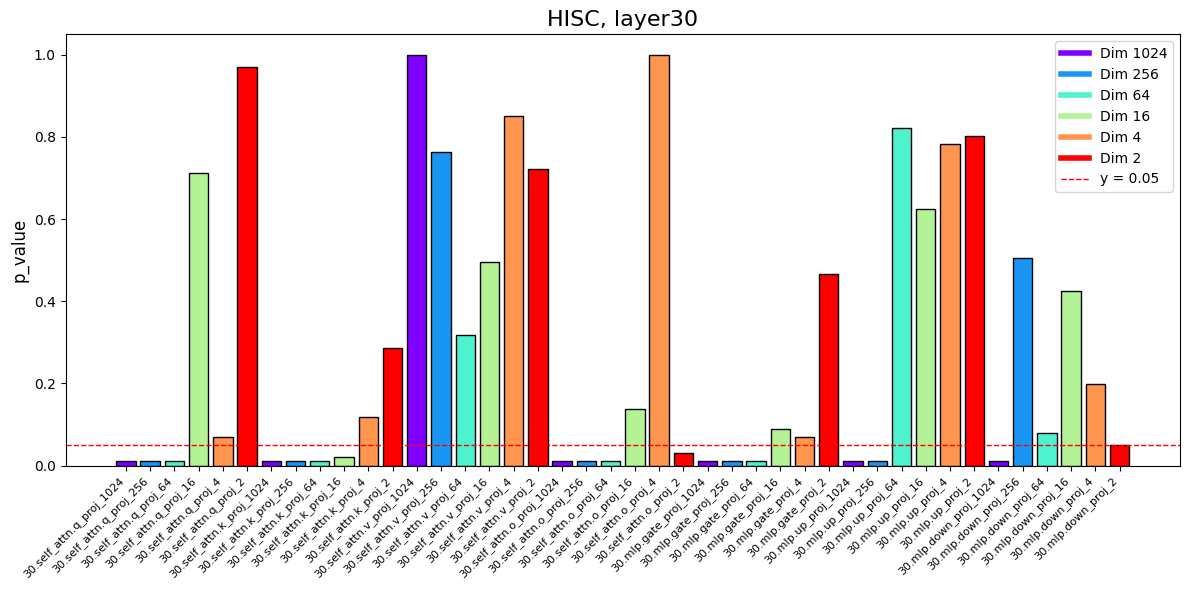

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import json
from matplotlib import cm

# 카테고리와 값을 추출
# dims = [1024, 512, 256, 128, 64, 32, 16, 8, 4, 2]
dims = [1024, 256, 64, 16, 4, 2]
categories = []
values = []
dim_indices = []  # dim 저장

dims = sorted(dims, reverse=True)

with open(f'/home/jgryu/Weight_compression/test_normality/dependency/perm_hisc_dim_{16}.json', 'r', encoding='utf-8') as file:
    plot_data = json.load(file)  # JSON 파일을 Python 객체로 변환
keys = plot_data.keys()

for k in keys:
    if 'layers.30.' in k:
        for dim in dims:
            with open(f'/home/jgryu/Weight_compression/test_normality/dependency/perm_hisc_dim_{dim}.json', 'r', encoding='utf-8') as file:
                plot_data = json.load(file)  # JSON 파일을 Python 객체로 변환
            v = plot_data[k]
            
            for transpose, dc_value in v.items():
                if transpose == 'True': 
                    continue
                categories.append(f"{'.'.join(k.split('.')[2:5])}_{dim}")
                values.append(dc_value)
                dim_indices.append(dim)

# 고유한 dim에 색상 매핑
unique_dims = sorted(set(dim_indices), reverse=True)
colors = cm.rainbow(np.linspace(0, 1, len(unique_dims)))
dim_color_map = {dim: color for dim, color in zip(unique_dims, colors)}
bar_colors = [dim_color_map[dim] for dim in dim_indices]

# 막대그래프 생성
plt.figure(figsize=(12, 6))
plt.bar(categories, values, color=bar_colors, edgecolor='black')

# y = 0.05 직선 추가
plt.axhline(y=0.05, color='red', linestyle='--', linewidth=1, label='y = 0.05')

# 그래프 레이블 추가
plt.title('HISC, layer30', fontsize=16)
plt.ylabel('p_value', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=8)

# dim별 색상 범례 추가
handles = [plt.Line2D([0], [0], color=dim_color_map[dim], lw=4, label=f'Dim {dim}') for dim in unique_dims]
handles.append(plt.Line2D([0], [0], color='red', linestyle='--', linewidth=1, label='y = 0.05'))
plt.legend(handles=handles, loc='upper right')

# 레이아웃 최적화 및 그래프 출력
plt.tight_layout()
plt.show()


## 3. Permutation Test + Distance Correlation

In [ ]:
import numpy as np
import dcor
from sklearn.metrics.pairwise import rbf_kernel
import json
# HSIC 계산 함수
def hsic(X, Y, sigma=1.0):
    K = rbf_kernel(X, X, gamma=1 / (2 * sigma**2))  # X의 RBF 커널
    L = rbf_kernel(Y, Y, gamma=1 / (2 * sigma**2))  # Y의 RBF 커널
    n = K.shape[0]
    H = np.eye(n) - (1/n) * np.ones((n, n))
    
    HSIC_value = np.trace(K @ H @ L @ H) / (n - 1)**2
    return HSIC_value

# # 독립 여부 판단
# if p_value > 0.05:
#     print("Variables are likely independent.")
# else:
#     print("Variables are dependent.")


# plot_data_perm_dc = {}
dims = [1024, 256, 128, 32, 8, 4, 2, 512, 64, 16]
# dim = 1024
for dim in dims:
    print('dim: ', dim)
    for k, v in state_dict.items():
        if 'embed' in k or 'layernorm' in k: continue
        if 'layers.0.' in k or 'layers.1.' in k or 'layers.10.' in k or 'layers.30.' in k:
        # if 'layers.30.' in k:
            print(k)
            plot_data_perm_dc[k] = {}
            for transpose in [False, True]:
                np.random.seed(1)
                print(f'Transpose : {transpose}')
                # print(f'#### chunk size : {dim} ####')
                if transpose:
                    v = v.T
                num_samples = 4096
                indices = torch.randperm(v.shape[0])[:num_samples]  # 무작위로 인덱스 선택
                W = v.reshape(-1, dim)[indices]
                # print(W.shape)

                d = W.shape[-1] // 2
                tensor_split = torch.split(W, d, dim=1)  # dim=1에서 64씩 나눔
                
                X = tensor_split[0]  # 첫 번째 (-1, 64)
                Y = tensor_split[1]  # 두 번째 (-1, 64)
                
                indices = torch.randperm(X.shape[0])
                X = X[indices]
                Y = Y[indices]

                dc_real = dcor.distance_correlation(X, Y)
                perm_dc = []
                num_permutations = 100
                for _ in range(num_permutations):
                    Y_perm = np.random.permutation(Y)  # Y를 무작위로 섞음
                    dc_perm = dcor.distance_correlation(X, Y_perm)
                    perm_dc.append(dc_perm)

                # p-value 계산
                p_value = (np.sum(np.array(perm_dc) >= dc_real) + 1) / (num_permutations + 1)
                plot_data_perm_dc[k][f'{transpose}'] = p_value
                print(p_value)
    output_filename = f"/home/jgryu/Weight_compression/test_normality/dependency/perm_dc_dim_{dim}_num_{num_samples}.json"
    with open(output_filename, 'w') as json_file:
        json.dump(plot_data_perm_dc, json_file, indent=4)

dim:  1024
model.layers.0.self_attn.q_proj.weight
Transpose : False
0.009900990099009901
Transpose : True
0.009900990099009901
model.layers.0.self_attn.k_proj.weight
Transpose : False
0.009900990099009901
Transpose : True
0.009900990099009901
model.layers.0.self_attn.v_proj.weight
Transpose : False
0.009900990099009901
Transpose : True
0.009900990099009901
model.layers.0.self_attn.o_proj.weight
Transpose : False


1024


/tmp/ipykernel_1924712/2204141498.py:44: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle((0, 0), 1, 1, color='skyblue', edgecolor='black'),  # False 색상
/tmp/ipykernel_1924712/2204141498.py:45: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle((0, 0), 1, 1, color='orange', edgecolor='black'),  # True 색상


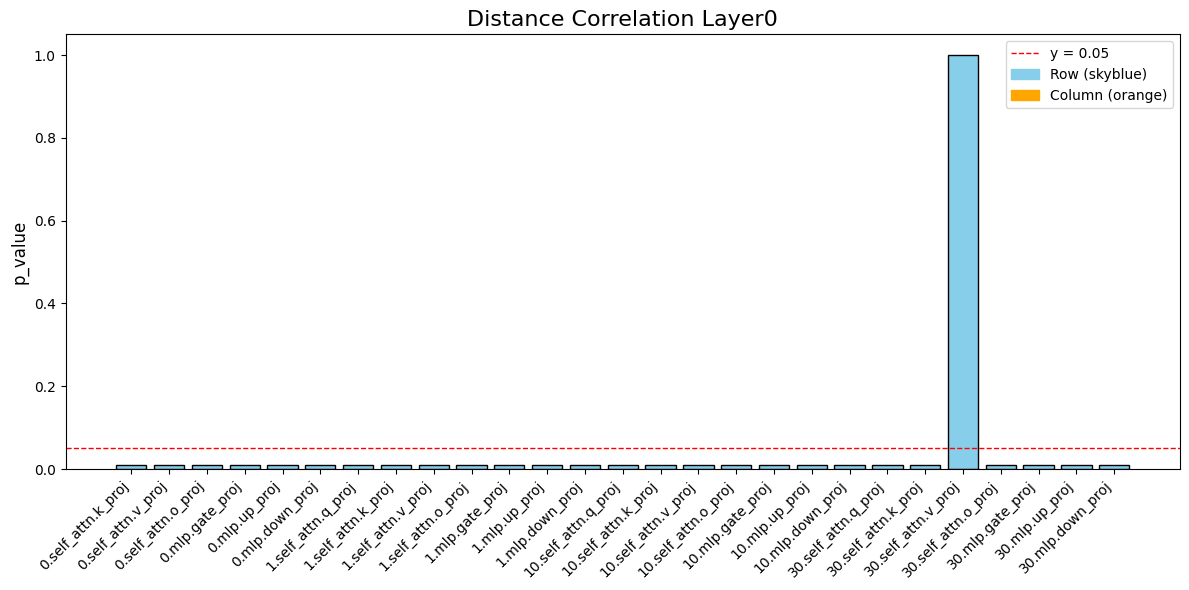

512


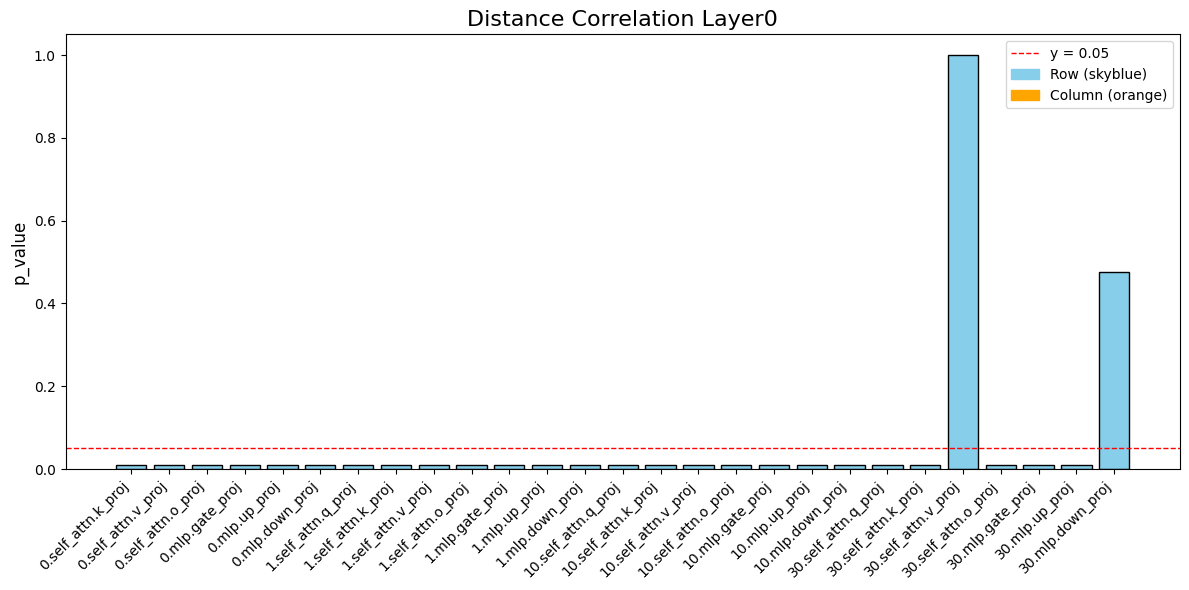

256


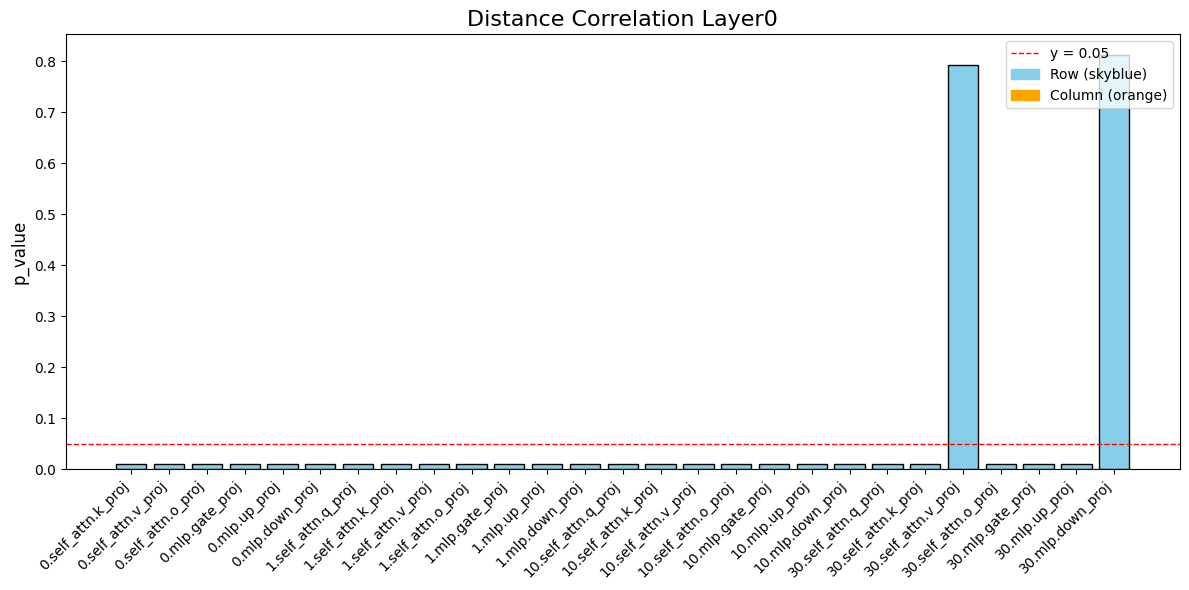

128


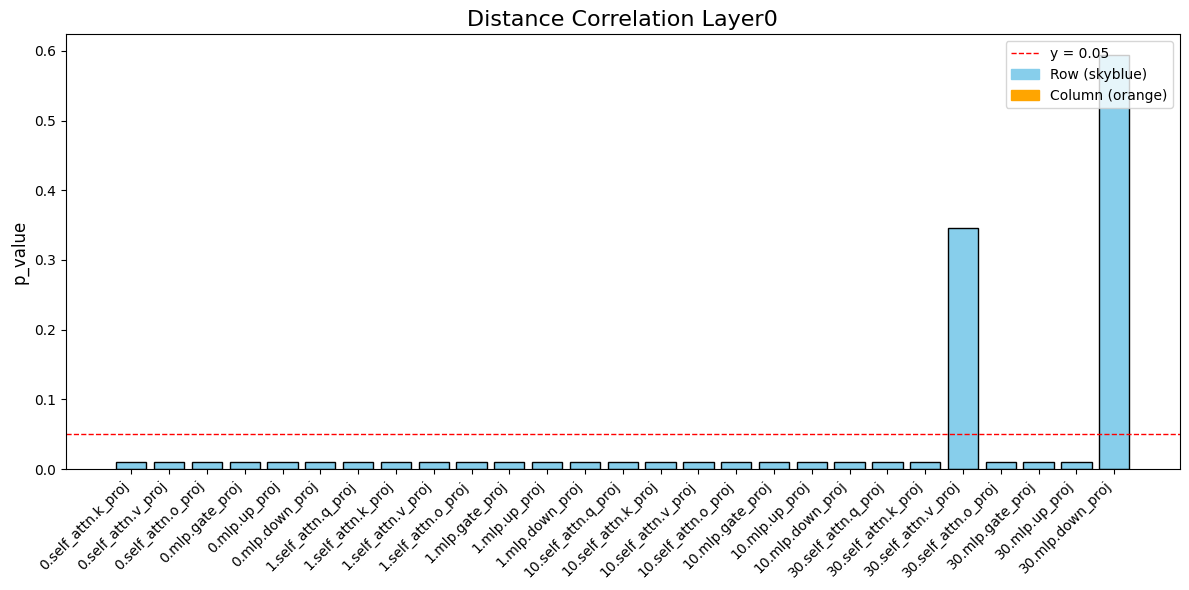

64


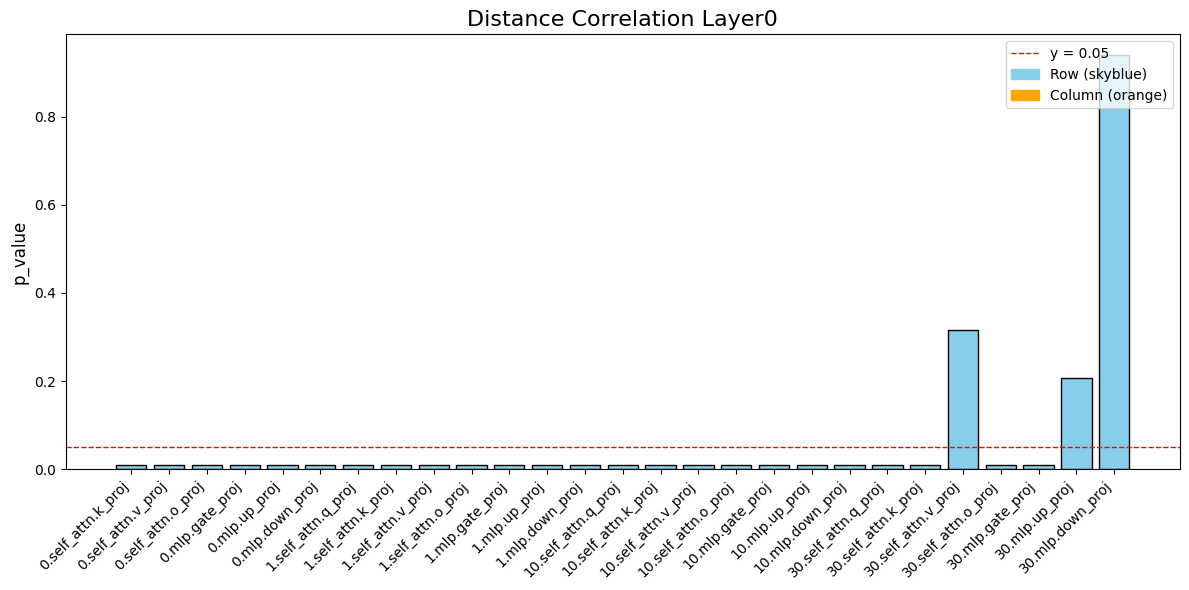

32


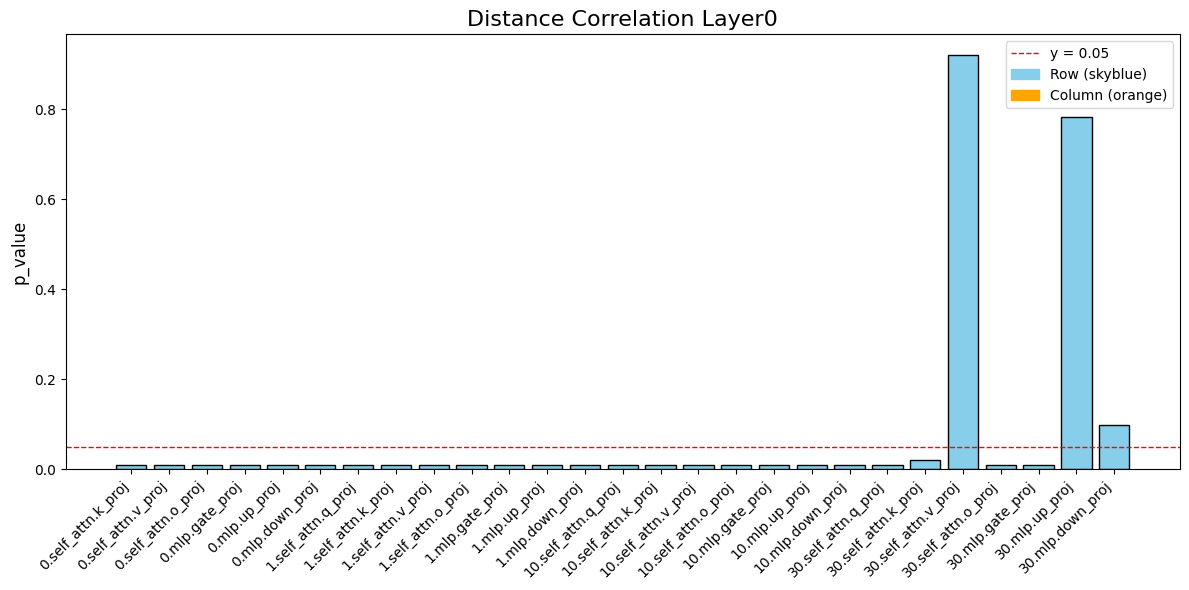

16


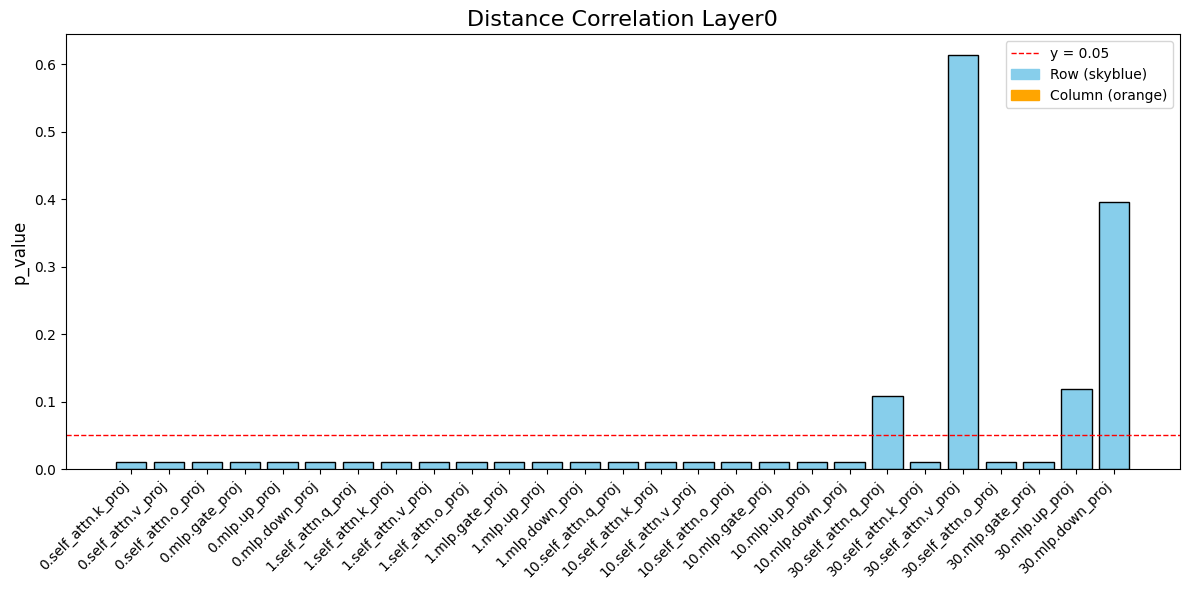

8


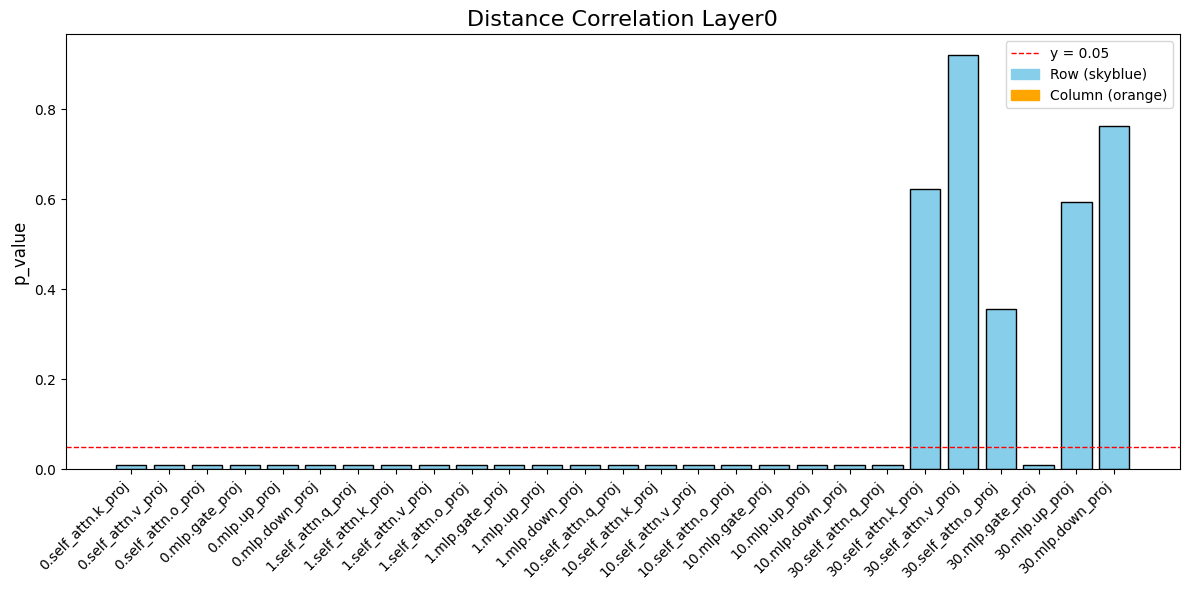

4


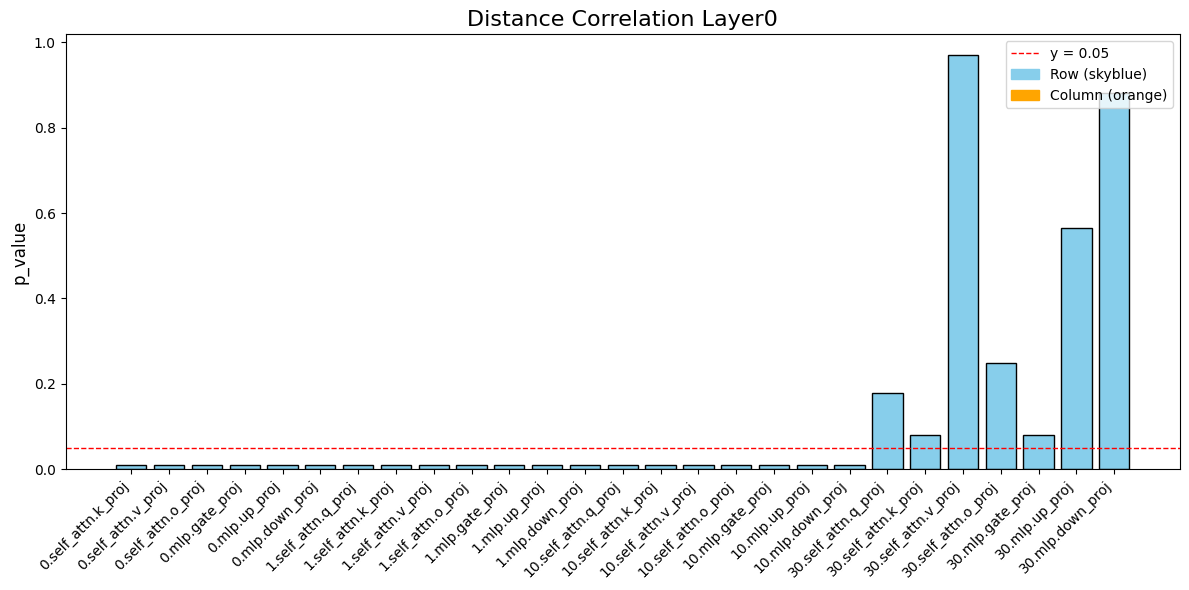

2


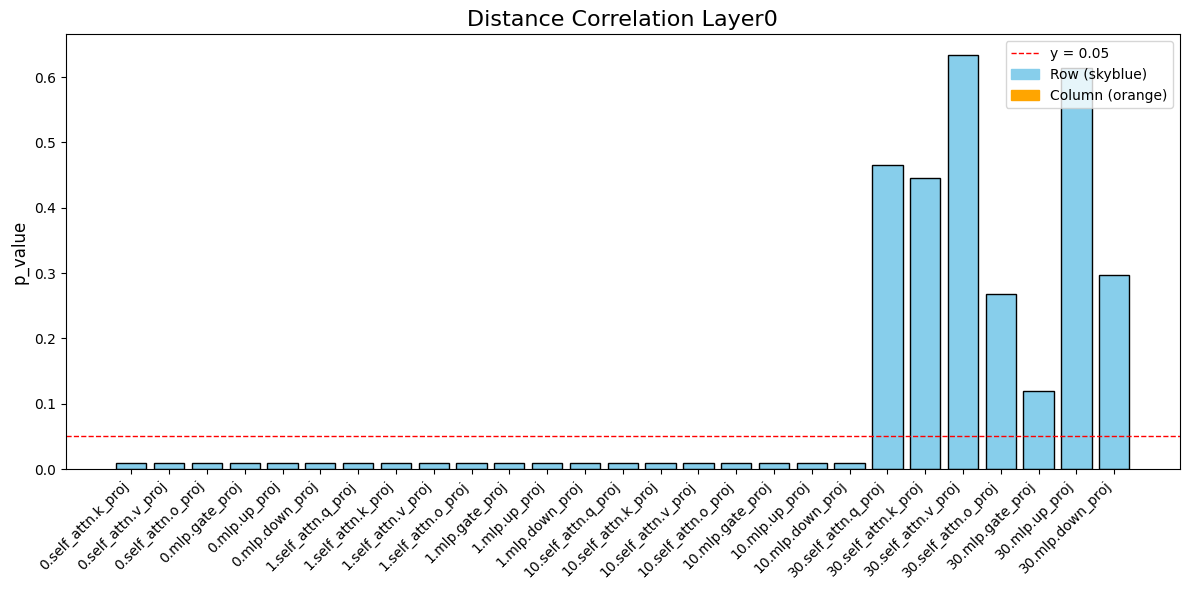

In [9]:
import matplotlib.pyplot as plt
import json
# 카테고리와 값을 추출
dims = [1024, 512, 256, 128, 64, 32, 16, 8, 4, 2]
for dim in dims:
    try:
        print(dim)
        with open(f'/home/jgryu/Weight_compression/test_normality/dependency/perm_dc_dim_{dim}.json', 'r', encoding='utf-8') as file:
            plot_data = json.load(file)  # JSON 파일을 Python 객체로 변환

        categories = []
        values = []
        colors = []  # 색상 저장
        for k, v in plot_data.items():
            if 'layers.0.' in k or 'layers.1.' in k or 'layers.10.' in k or 'layers.30.' in k:
            # if 'layers.0.' in k:
                for transpose, dc_value in v.items():
                    if transpose == 'False':
                        # categories.append(f"{'.'.join(k.split('.')[2:5])}_{transpose}")
                        categories.append(f"{'.'.join(k.split('.')[2:5])}")
                        values.append(dc_value)
                        colors.append('skyblue' if transpose == 'False' else 'orange')  # False는 skyblue, True는 orange

        # 막대그래프 생성
        plt.figure(figsize=(12, 6))
        plt.bar(categories, values, color=colors, edgecolor='black')

        # y = 1e-3 직선 추가
        plt.axhline(y=0.05, color='red', linestyle='--', linewidth=1, label='y = 0.05')

        # 그래프 레이블 추가
        plt.title('Distance Correlation Layer0', fontsize=16)
        plt.ylabel('p_value', fontsize=12)
        plt.xticks(rotation=45, ha='right', fontsize=10)  # 폰트 크기 8로 조정

        # # 각 막대 위에 값 표시
        # for i, value in enumerate(values):
        #     plt.text(i, value + 0.01, f"{value:.2f}", ha='center', fontsize=10)

        # 범례 추가
        plt.legend(
            [
                plt.Line2D([0], [0], color='red', linestyle='--', linewidth=1),  # y=1e-3 직선
                plt.Rectangle((0, 0), 1, 1, color='skyblue', edgecolor='black'),  # False 색상
                plt.Rectangle((0, 0), 1, 1, color='orange', edgecolor='black'),  # True 색상
            ],
            ['y = 0.05', 'Row (skyblue)', 'Column (orange)'],  # 각각의 라벨
            loc='upper right'
        )

        # 레이아웃 최적화 및 그래프 출력
        plt.tight_layout()
        plt.show()

    except:
        continue
    
# # 독립 여부 판단
# if p_value > 0.05:
#     print("Variables are likely independent.")
# else:
#     print("Variables are dependent.")

## 크면 독립

1024


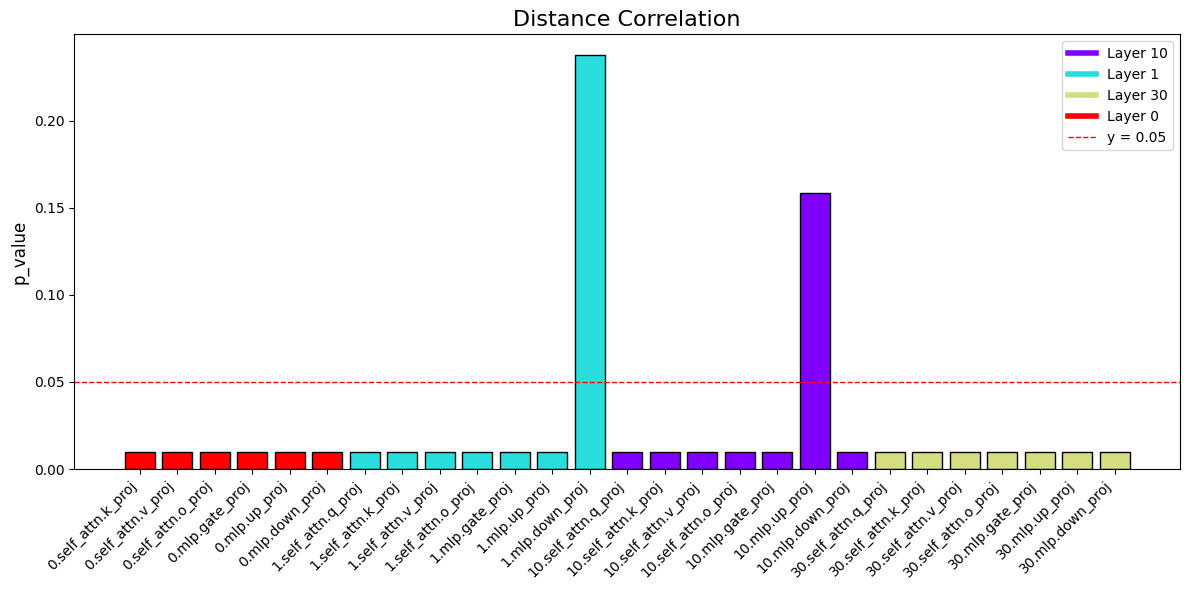

512


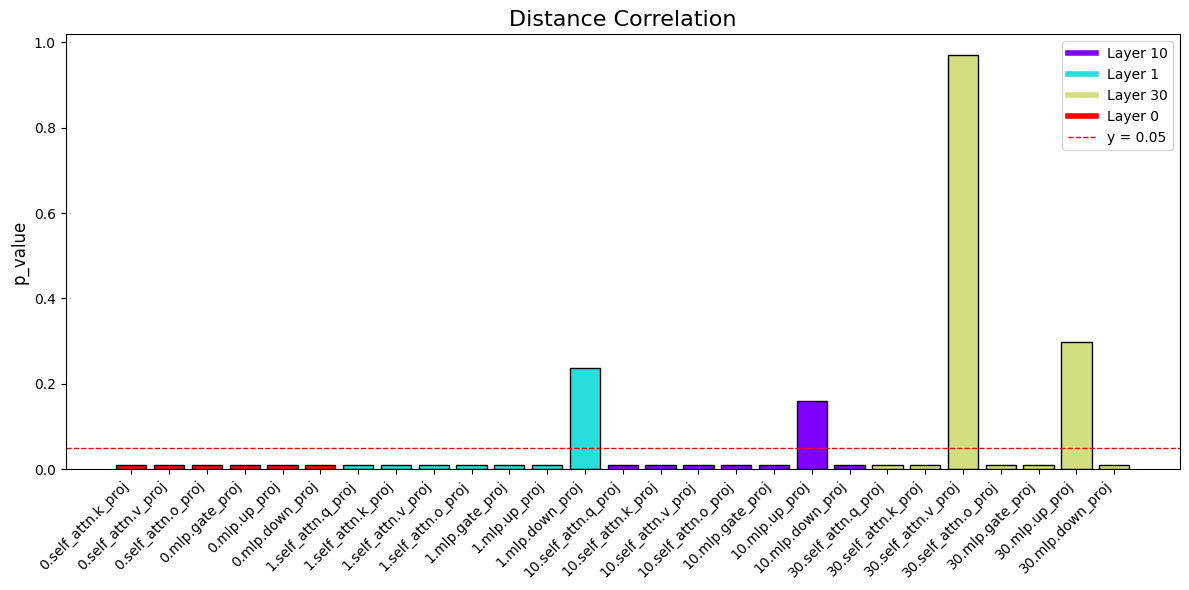

256


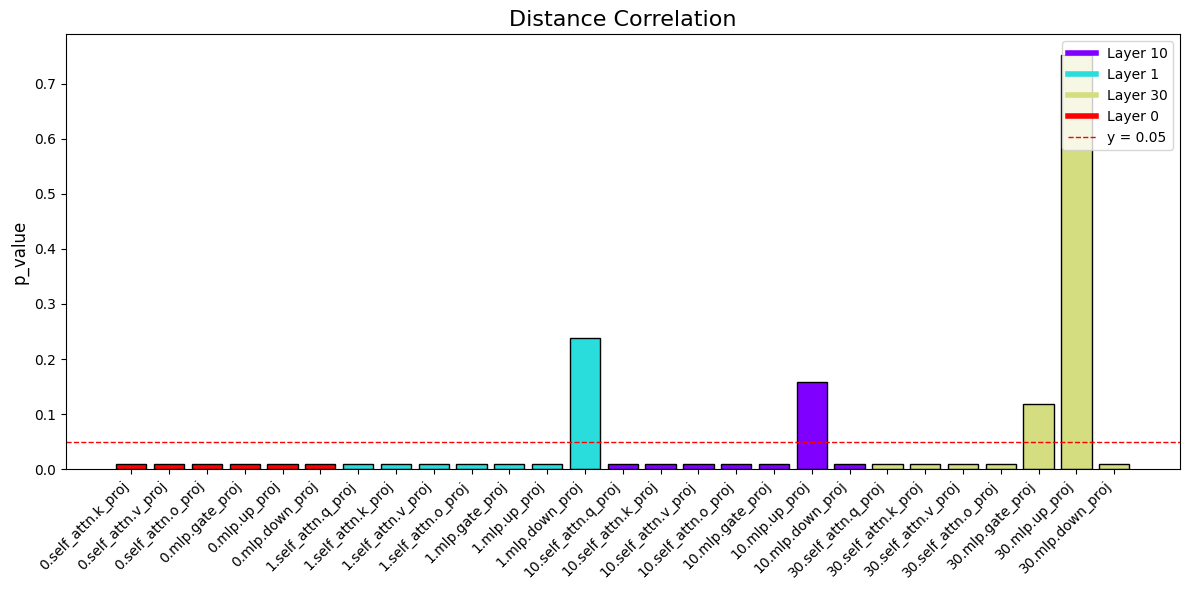

128


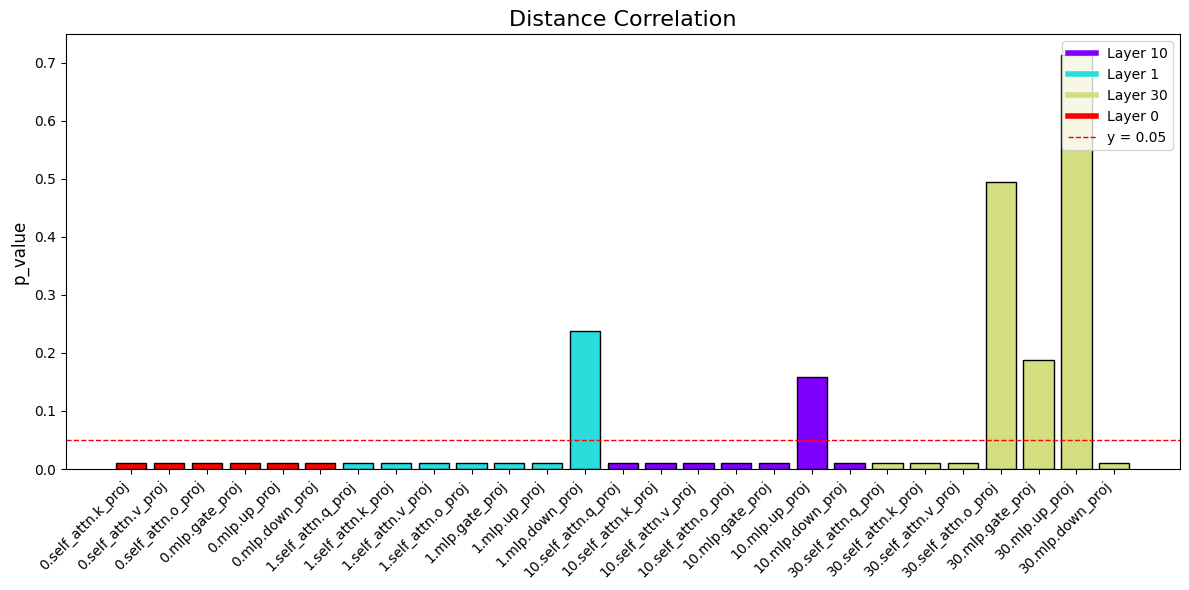

64


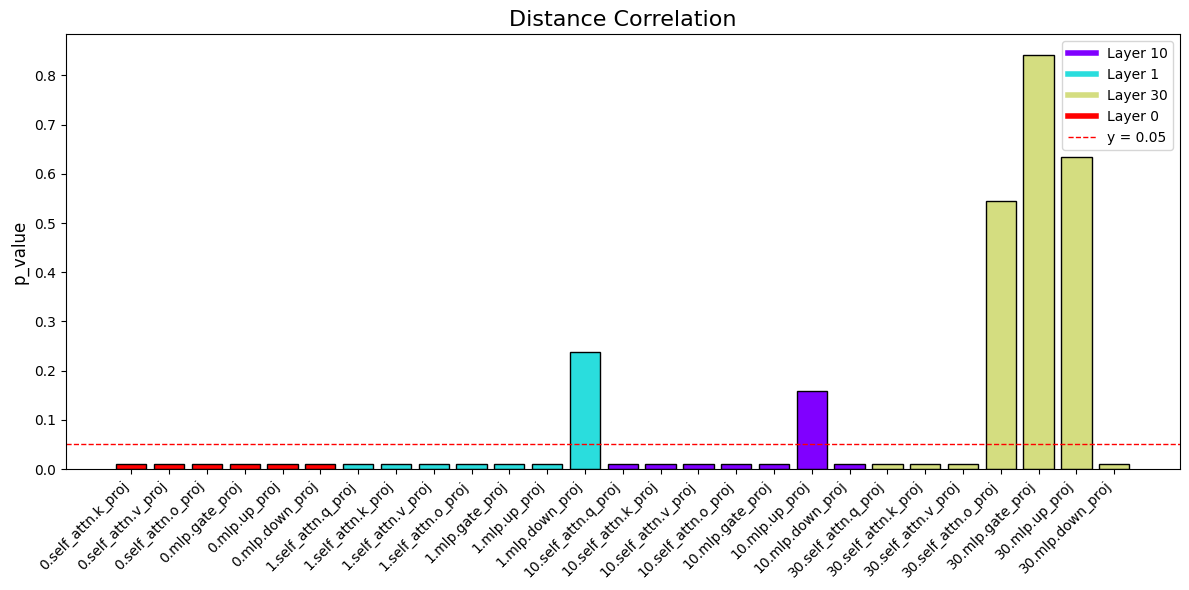

32


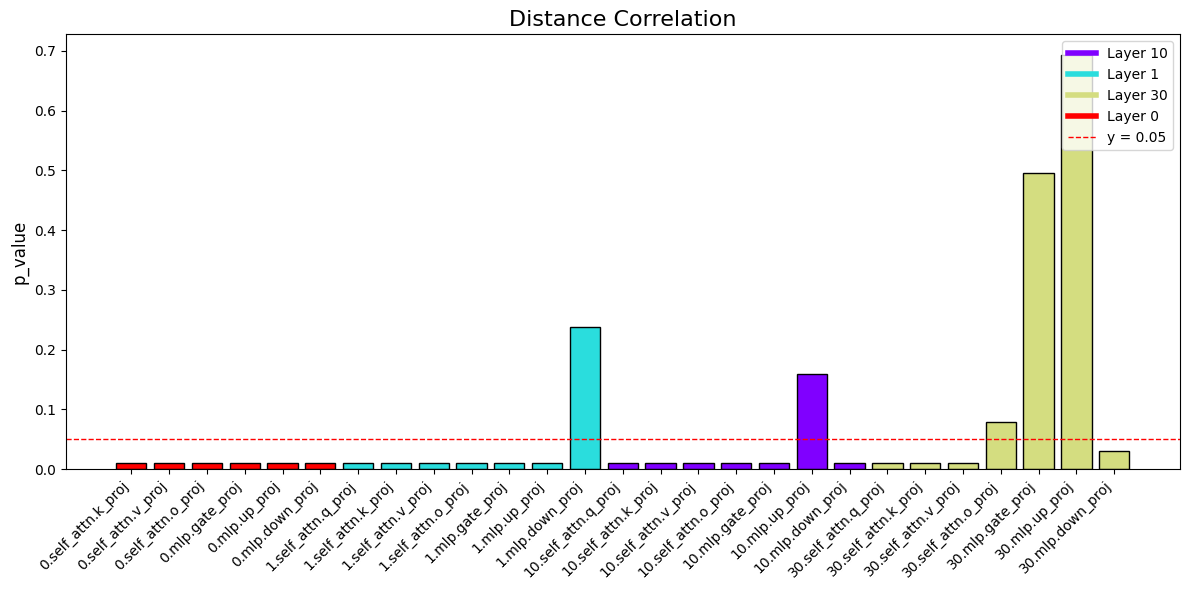

16


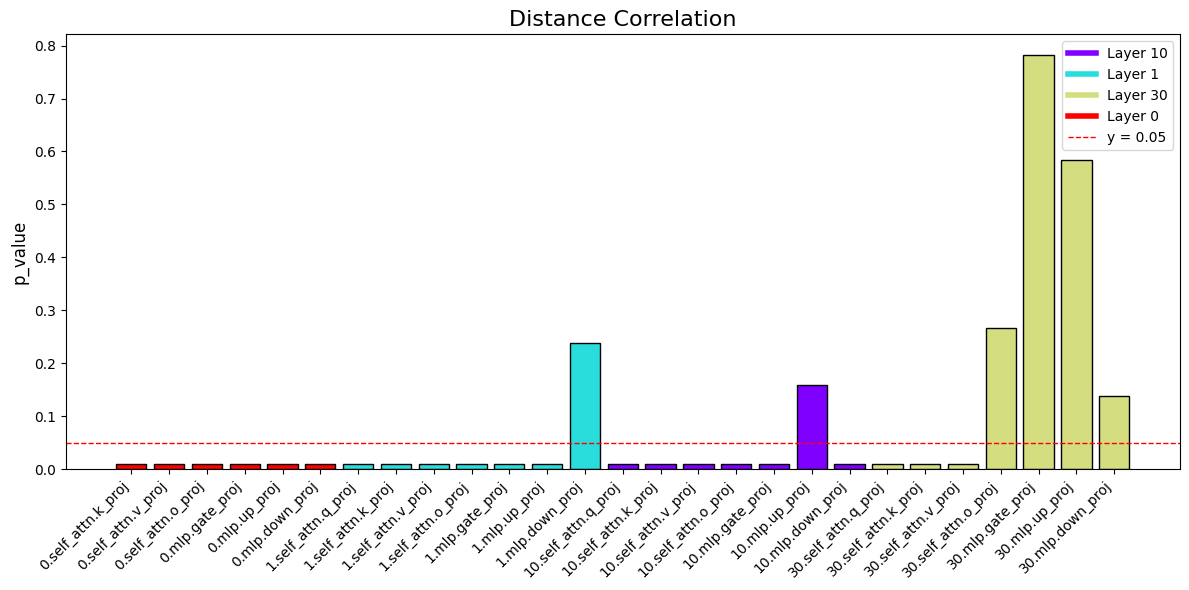

8


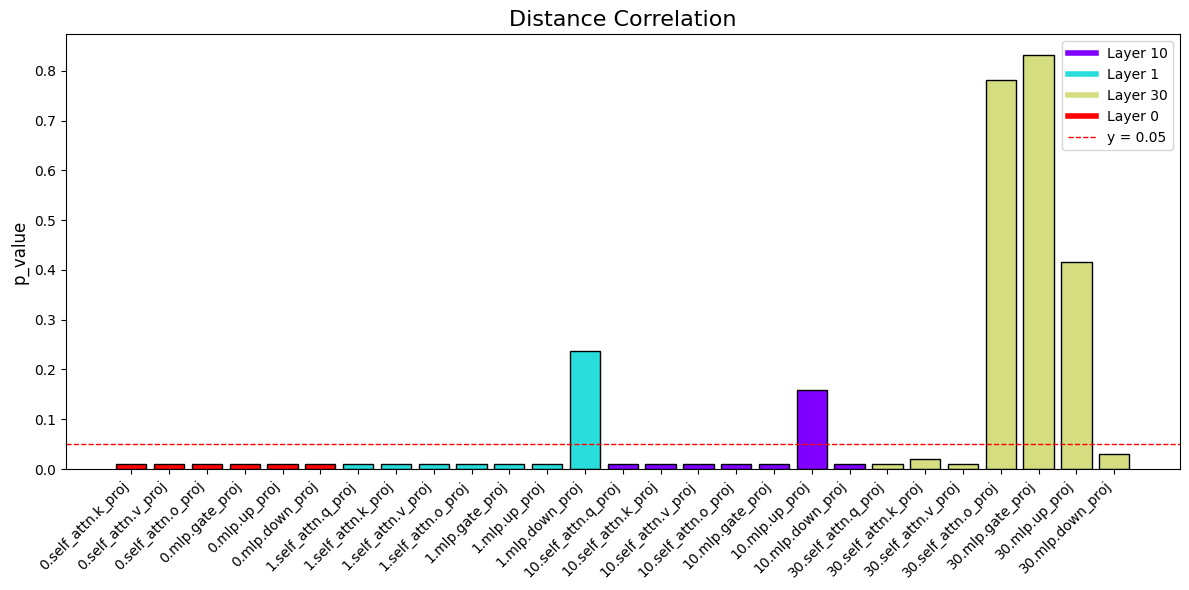

4


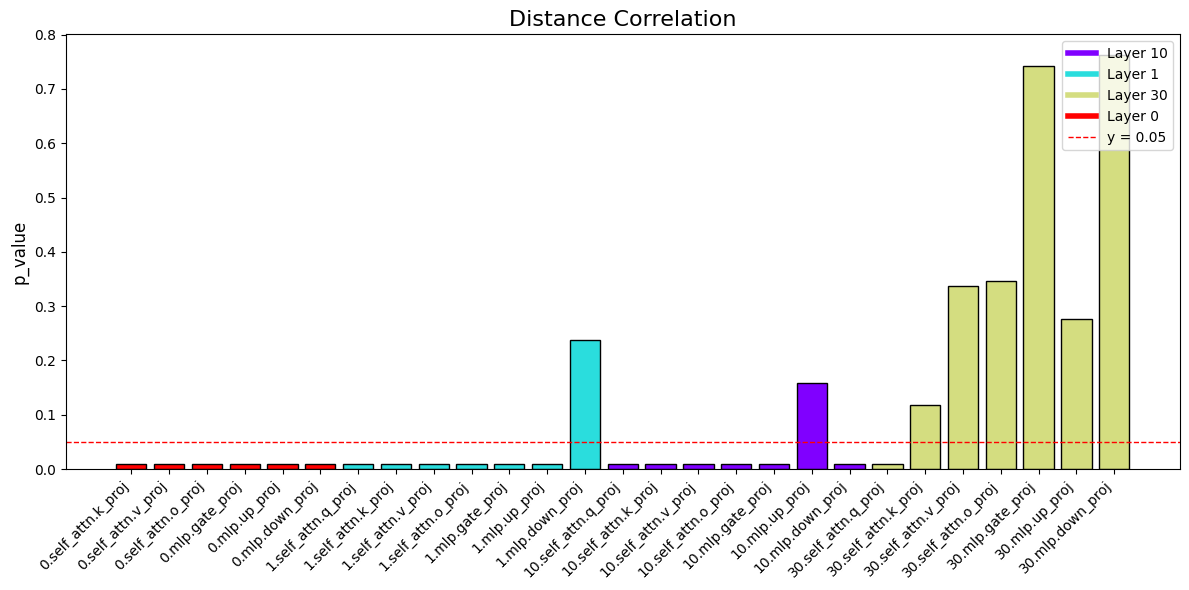

2


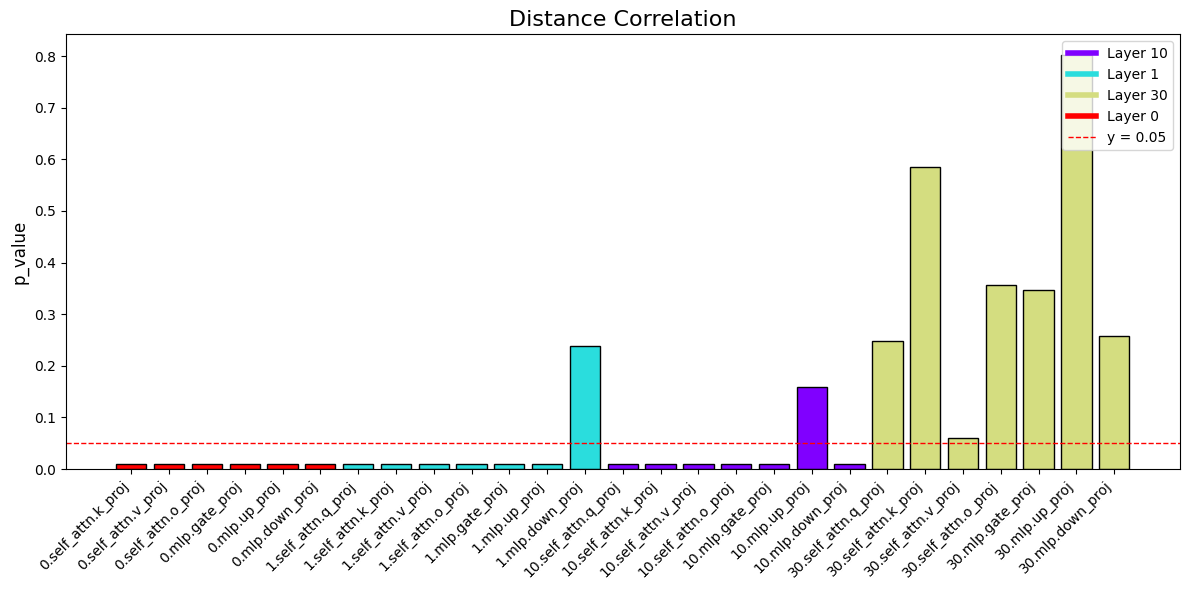

In [4]:
import matplotlib.pyplot as plt
import json
import matplotlib.cm as cm
import numpy as np

# 카테고리와 값을 추출
dims = [1024, 512, 256, 128, 64, 32, 16, 8, 4, 2]
for dim in dims:
    try:
        print(dim)
        with open(f'/home/jgryu/Weight_compression/test_normality/dependency/perm_dc_dim_{dim}.json', 'r', encoding='utf-8') as file:
            plot_data = json.load(file)  # JSON 파일을 Python 객체로 변환

        categories = []
        values = []
        layer_indices = []  # layer index 저장
        for k, v in plot_data.items():
            if 'layers.0.' in k or 'layers.1.' in k or 'layers.10.' in k or 'layers.30.' in k:
                for transpose, dc_value in v.items():
                    if transpose == 'True':
                        categories.append(f"{'.'.join(k.split('.')[2:5])}")
                        values.append(dc_value)
                        layer_indices.append(k.split('.')[2])  # layer index 추출

        # 고유한 layer index에 색상 매핑
        unique_layers = list(set(layer_indices))
        colors = cm.rainbow(np.linspace(0, 1, len(unique_layers)))
        layer_color_map = {layer: color for layer, color in zip(unique_layers, colors)}
        bar_colors = [layer_color_map[layer] for layer in layer_indices]

        # 막대그래프 생성
        plt.figure(figsize=(12, 6))
        plt.bar(categories, values, color=bar_colors, edgecolor='black')

        # y = 1e-3 직선 추가
        plt.axhline(y=0.05, color='red', linestyle='--', linewidth=1, label='y = 0.05')

        # 그래프 레이블 추가
        plt.title(f'Distance Correlation', fontsize=16)
        plt.ylabel('p_value', fontsize=12)
        plt.xticks(rotation=45, ha='right', fontsize=10)

        # 범례 추가 (layer index와 색상 매핑)
        legend_handles = [
            plt.Line2D([0], [0], color=color, lw=4, label=f'Layer {layer}')
            for layer, color in layer_color_map.items()
        ]
        legend_handles.append(
            plt.Line2D([0], [0], color='red', linestyle='--', linewidth=1, label='y = 0.05')
        )
        plt.legend(handles=legend_handles, loc='upper right')

        # 레이아웃 최적화 및 그래프 출력
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error processing dim {dim}: {e}")
        continue


In [ ]:
import matplotlib.pyplot as plt
import json
import matplotlib.cm as cm
import numpy as np

# 카테고리와 값을 추출
dims = [1024, 512, 256, 128, 64, 32, 16, 8, 4, 2]
for dim in dims:
    try:
        print(dim)
        with open(f'/home/jgryu/Weight_compression/test_normality/dependency/perm_dc_dim_{dim}.json', 'r', encoding='utf-8') as file:
            plot_data = json.load(file)  # JSON 파일을 Python 객체로 변환

        categories = []
        values = []
        layer_indices = []  # layer index 저장
        for k, v in plot_data.items():
            # if 'layers.0.' in k or 'layers.1.' in k or 'layers.10.' in k or 'layers.30.' in k:
            if 'layers.0.' in k:
                for transpose, dc_value in v.items():
                    if transpose == 'False':
                        categories.append(f"{'.'.join(k.split('.')[2:5])}")
                        values.append(dc_value)
                        layer_indices.append(k.split('.')[2])  # layer index 추출

        # 고유한 layer index에 색상 매핑
        unique_layers = list(set(layer_indices))
        colors = cm.rainbow(np.linspace(0, 1, len(unique_layers)))
        layer_color_map = {layer: color for layer, color in zip(unique_layers, colors)}
        bar_colors = [layer_color_map[layer] for layer in layer_indices]

        # 막대그래프 생성
        plt.figure(figsize=(12, 6))
        plt.bar(categories, values, color=bar_colors, edgecolor='black')

        # y = 1e-3 직선 추가
        plt.axhline(y=0.05, color='red', linestyle='--', linewidth=1, label='y = 0.05')

        # 그래프 레이블 추가
        plt.title(f'Distance Correlation', fontsize=16)
        plt.ylabel('p_value', fontsize=12)
        plt.xticks(rotation=45, ha='right', fontsize=10)

        # 범례 추가 (layer index와 색상 매핑)
        legend_handles = [
            plt.Line2D([0], [0], color=color, lw=4, label=f'Layer {layer}')
            for layer, color in layer_color_map.items()
        ]
        legend_handles.append(
            plt.Line2D([0], [0], color='red', linestyle='--', linewidth=1, label='y = 0.05')
        )
        plt.legend(handles=legend_handles, loc='upper right')

        # 레이아웃 최적화 및 그래프 출력
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error processing dim {dim}: {e}")
        continue


In [ ]:
import dcor
import numpy as np

# 샘플 데이터 생성
# np.random.seed(0)
# X = np.random.rand(1000, 50)  # 50차원 데이터
# Y = np.random.rand(1000, 50)  # 독립적인 50차원 데이터

# # 실제 Distance Correlation 계산
# dc_real = dcor.distance_correlation(X, Y)

# # Permutation Test
# perm_dc = []
# num_permutations = 100
# for _ in range(num_permutations):
#     Y_perm = np.random.permutation(Y)  # Y를 무작위로 섞음
#     dc_perm = dcor.distance_correlation(X, Y_perm)
#     perm_dc.append(dc_perm)

# # p-value 계산
# p_value = (np.sum(np.array(perm_dc) >= dc_real) + 1) / (num_permutations + 1)

# print(f"Real Distance Correlation: {dc_real:.4f}")
# print(f"p-value: {p_value:.4f}")

# # 독립 여부 판단
# if p_value > 0.05:
#     print("Variables are likely independent.")
# else:
#     print("Variables are dependent.")

plot_data = {}
dims = [4096, 2048, 1024, 512, 256, 128, 64, 32, 16, 8, 4, 2]

for k, v in state_dict.items():
    if 'layers.0' in k or 'layers.1' in k or 'layers.10' in k or 'layers.30' in k:
        if 'layernorm' in k: continue
        for transpose in [False, True]:
            print(k, v.shape)
            np.random.seed(1)
            # print(f'Transpose : {transpose}')
            plot_data[f'{transpose}'] = []
            for dim in dims:
                # print(f'#### chunk size : {dim} ####')
                if transpose:
                    v = v.T
                v = v.reshape(-1, dim)
                num_samples = 2000
                indices = torch.randperm(v.shape[0])[:num_samples]  # 무작위로 인덱스 선택
                W = v[indices]

                d = W.shape[-1] // 2
                tensor_split = torch.split(W, d, dim=1)  # dim=1에서 64씩 나눔
                
                X = tensor_split[0]  # 첫 번째 (-1, 64)
                Y = tensor_split[1]  # 두 번째 (-1, 64)
                
                indices = torch.randperm(X.shape[0])
                X = X[indices]
                Y = Y[indices]
                # print(X.shape, Y.shape)

                dc_real = dcor.distance_correlation(X, Y)
                perm_dc = []
                num_permutations = 10
                for _ in range(num_permutations):
                    Y_perm = np.random.permutation(Y)  # Y를 무작위로 섞음
                    dc_perm = dcor.distance_correlation(X, Y_perm)
                    perm_dc.append(dc_perm)

                # p-value 계산
                p_value = (np.sum(np.array(perm_dc) >= dc_real) + 1) / (num_permutations + 1)
                plot_data[f'{transpose}'].append(p_value)

                # print(f"Real Distance Correlation: {dc_real}")
                # print(f"p-value: {p_value}")
                
                # if p_value > 0.05:
                #     print("Variables are likely independent.")
                # else:
                #     print("Variables are dependent.")

                    
        import matplotlib.pyplot as plt
        dims = [4096, 2048, 1024, 512, 256, 128, 64, 32, 16, 8, 4, 2]
        plt.figure(figsize=(6.5, 5))
        for l, v in plot_data.items():
            print(v)
            plt.plot(dims, v, marker='o', markersize = 3, linestyle='-', label=l)
            
            
        plt.title(f'{k},  Permutation Test + Distance Correlation')
        plt.xlabel('size')
        plt.ylabel('p_value')
        plt.legend()
        plt.grid(True)
        plt.xscale('log')

        plt.tight_layout()
        plt.show()



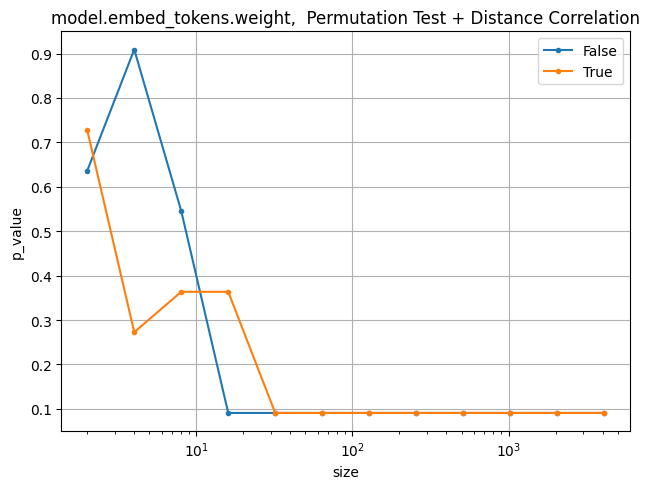